# Example using netcdf-scm

This example is adapted from the notebook by Zeb Nicholls: see https://gitlab.com/netcdf-scm/calibration-data/-/blob/master/notebooks/plotting/ecs-diagnosis.ipynb

It goes through how to download data using netcdf-scm and creates 4xCO2 "Gregory plots" - used for determining climate sensitivity of CMIP models. 

Here we calculate the equilibrium climate sensitivity of CMIP6 models using the [Gregory et al., GRL 2004](https://doi.org/10.1029/2003GL018747) method as described by [Zelinka et al., GRL 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL085782). This means that the ECS is calculated using regressions of global- and annual-mean values.

In [1]:
import datetime as dt
import glob
import os.path
import requests
import shutil
import zipfile

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import netcdf_scm.io
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tqdm.autonotebook as tqdman
from openscm_units import unit_registry
from patsy import dmatrices
from scmdata import ScmRun, run_append
from climateforcing.utils import mkdir_p

/Users/chris/anaconda3/envs/cmip6-examples/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_5877/2309422446.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


usually, 4xCO2 experiments are run for 150/151 years

In [2]:
NYEARS_TO_REGRESS = 151

because for 4xCO2 and piControl experiments, the actual "date" given in the climate model doesn't really matter, and every model is different as they are spun up from long simulations. So we want to normalise this in the metadata we pass to netcdf-scm.

In [3]:
def force_first_year(inp, new_first_year_value=1):
    """
    Force first year of an :obj:`ScmRun` to match a given value
    """
    ts = inp.timeseries()
    first_year = inp["year"].min()
    ts.columns = ts.columns.map(
        lambda x: dt.datetime(
            x.year - first_year + new_first_year_value, x.month, x.day
        )
    )

    out = ScmRun(ts)
    out.metadata = inp.metadata

    return out

One issue of working with climate data that is not uncommon is that not all variables that you need from each model will be available, so this function will highlight this fact and cause a file-not-found instance to not cause an error.

In [4]:
def find_file(srch):
    found_files = set(glob.glob(srch, recursive=True))
    if len(found_files) != 1:
        print("Not all data available for {}".format(srch))
        print(found_files)
        return None

    return list(found_files)[0]

## Specific function for making the Gregory plots

In [5]:
def get_gregory_plot_df(inp, years=None, units=True, scenario="abrupt*4xCO2"):
    pdf = inp.filter(scenario=scenario).time_mean("AC")

    if years is not None:
        pdf = pdf.filter(year=years)

    pdf = pdf.timeseries(time_axis="year").unstack(["variable", "unit"]).stack("time")

    if units:
        pdf.columns = pdf.columns.map(lambda x: "{} ({})".format(*x))

        return pdf.reset_index()

    else:
        pdf.columns = pdf.columns.map(lambda x: "{}".format(x[0]))
        tas_units = inp.filter(variable="tas").get_unique_meta(
            "unit", no_duplicates=True
        )
        rndt_units = inp.filter(variable="rndt").get_unique_meta(
            "unit", no_duplicates=True
        )

        return pdf.reset_index(), {"tas": tas_units, "rndt": rndt_units}

In [6]:
def get_gregory_values(inp):
    pdf, units = get_gregory_plot_df(
        inp, years=range(1, 1 + NYEARS_TO_REGRESS + 1), units=False
    )

    y, X = dmatrices("rndt ~ tas", data=pdf, return_type="dataframe")
    mod = sm.OLS(y, X)
    res = mod.fit()

    intercept = res.params["Intercept"]
    gradient = res.params["tas"]
    lambda_val = -gradient * unit_registry("{rndt} / {tas}".format(**units))
    forcing_4xco2 = intercept * unit_registry("{rndt}".format(**units))
    forcing_2xco2 = forcing_4xco2 / 2
    ecs = forcing_2xco2 / lambda_val

    return {
        "lambda": lambda_val,
        "rf_4xco2": forcing_4xco2,
        "rf_2xco2": forcing_2xco2,
        "ecs": ecs,
    }

In [7]:
def make_gregory_plot(inp, ax, style=None):
    plt_unit = "W m^-2"

    pdf = get_gregory_plot_df(inp, scenario="*")
    regress_years_label = "Year 1-{}".format(NYEARS_TO_REGRESS)
    pdf[regress_years_label] = pdf["time"] <= NYEARS_TO_REGRESS

    gregory_values = get_gregory_values(inp)

    scat_kwgs = dict(
        data=pdf,
        y="rndt (watt / meter ** 2)",
        x="tas (K)",
        hue=regress_years_label,
        ax=ax,
    )
    if style is not None:
        scat_kwgs["style"] = style

    ax = sns.scatterplot(**scat_kwgs)

    rf_4xco2 = gregory_values["rf_4xco2"]
    lambda_val = gregory_values["lambda"]
    ax.plot(
        ax.get_xlim(),
        (rf_4xco2 - (lambda_val * (ax.get_xlim() * unit_registry("K"))))
        .to(plt_unit)
        .magnitude,
        label="Gregory regression (\n ECS: {:.2f} \n lambda: {:.2f} \n rf 2xCO2: {:.2f}\n)".format(
            gregory_values["ecs"],
            lambda_val,
            gregory_values["rf_2xco2"],
        ),
        color="grey",
    )
    ax.legend()
    ax.set_title(
        "{} {}".format(
            db.get_unique_meta("climate_model", no_duplicates=True),
            db.get_unique_meta("member_id", no_duplicates=True),
        )
    )

    return ax

## Download the data

First we need to download the tas, rsut, rlut and rsdt data for the abrupt-\*CO2 experiments. Here we want to use the normalised data i.e. timeseries which are anomalies from a 21-year running mean of the piControl. We also use the annual-mean data.

In [8]:
FORCE_DOWNLOAD = True

In [9]:
DATA_DIR = os.path.join("..", "data", "netcdf-scm")
DATA_DIR

'../data/netcdf-scm'

In [10]:
zip_file = os.path.join("..", "data", "netcdf-scm", "ecs_data.zip")
zip_file

'../data/netcdf-scm/ecs_data.zip'

In [11]:
experiments_to_download = (
    "abrupt-4xCO2",
    "abrupt4xCO2",
    "abrupt-2xCO2",
    "abrupt-0p5xCO2",
)

variables_to_download = (
    "tas",
    "rsut",
    "rlut",
    "rsdt",
)

if FORCE_DOWNLOAD:
    if os.path.isdir(DATA_DIR):
        shutil.rmtree(DATA_DIR)

if not os.path.isdir(DATA_DIR):
    mkdir_p(DATA_DIR)
    print("Downloading ECS relevant data")
    for exp in tqdman.tqdm(experiments_to_download, desc="experiment"):
        for var in tqdman.tqdm(variables_to_download, desc="variable"):
            params = (
                ("experiment_id", exp),
                ("variable_id", var),
                ("normalised", "21-yr-running-mean"),
                ("timeseriestype", "average-year-mid-year"),
            )
            url = "https://cmip6.science.unimelb.edu.au/api/v1/download_zip"
            r = requests.get(url, params=params)
            r.raise_for_status()

            with open(zip_file, "wb") as f:
                f.write(r.content)

            zip_ref = zipfile.ZipFile(zip_file, "r")
            zip_ref.extractall(DATA_DIR)
            zip_ref.close()

experiment:   0%|          | 0/4 [00:00<?, ?it/s]

variable:   0%|          | 0/4 [00:00<?, ?it/s]

variable:   0%|          | 0/4 [00:00<?, ?it/s]

variable:   0%|          | 0/4 [00:00<?, ?it/s]

variable:   0%|          | 0/4 [00:00<?, ?it/s]

### README

Before using the data, please examine the README

In [12]:
with open(os.path.join(DATA_DIR, "README.txt"), "r") as fh:
    print(fh.read())

README
------

Acknowledging CMIP

The data provided here are derived from the outputs of the `Coupled Model Intercomparison Project <https://www.wcrp-climate.org/wgcm-cmip>`_ data.
This means that you **must** abide by the terms of use of the data, in particular the required acknowledgement statements (see the `CMIP5 terms of use <https://pcmdi.llnl.gov/mips/cmip5/terms-of-use.html>`_ and `CMIP6 terms of use <https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html>`_).

To make it easier to do this, we have developed some basic tools which simplify the process of checking model license terms and creating the tables required in publications to cite CMIP data (see the `our tools here <https://netcdf-scm.readthedocs.io/en/latest/usage/using-cmip-data.html>`_).
However, we provide no guarantees that these tools are up to date so all users should double check that they do in fact produce output consistent with the terms of use referenced above (and if there are issues, please raise an i

## Let's quickly examine what the data actually looks like in netcdf-scm format

It's basically a text file, with data in tab-delimited format with some metadata as a header.

You can work with these files directly, or use tools within the netcdf-scm package to work with the data.

In [13]:
with open('../data/netcdf-scm/average-year-mid-year/CMIP6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i1p2f1/Amon/tas/gn/v20190429/NORMED_netcdf-scm_tas_Amon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_1850-2000.MAG') as fh:
    print(fh.read())

---- HEADER ----

Date: 2020-11-28 04:11:06
Contact: Zebedee Nicholls <zebedee.nicholls@climate-energy-college.org>, Jared Lewis <jared.lewis@climate-energy-college.org>, Malte Meinshausen <malte.meinshausen@unimelb.edu.au>
Source data crunched with: netCDF-SCM v2.0.0rc7+3.g5d380c44 (more info at gitlab.com/netcdf-scm/netcdf-scm)
File written with: pymagicc v2.0.0rc8+12.g07a7e9f (more info at github.com/openclimatedata/pymagicc)

For more information on the AR6 regions (including mapping the abbrevations to their full names), see: https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-regions, specifically https://github.com/SantanderMetGroup/ATLAS/blob/master/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv (paper is at https://doi.org/10.5194/essd-2019-258)

---- METADATA ----

(child) CCCma_model_hash: 8ac7a3c953a92eb65289508ded4d1b280d2bae9e
(child) CCCma_parent_runid: p2-pictrl
(child) CCCma_pycmor_hash: 33c30511acc319a98240633965a04ca99c26427e
(child) CCC

## Making plots

In [14]:
abrupt_4xco2_tas_files = sorted(
    glob.glob(
        os.path.join(
            DATA_DIR,
            "**",
            "average-year-mid-year",
            "**",
            "NORMED*tas*abrupt*4xCO2*.MAG",
        ),
        recursive=True,
    )
)
len(abrupt_4xco2_tas_files)

136

  0%|          | 0/136 [00:00<?, ?it/s]

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/AWI/AWI-CM-1-1-MR/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20191015/**/NORMED*.MAG
set()
Not all data available for AWI-CM-1-1-MR r1i1p1f1
Missing abrupt-2xCO2


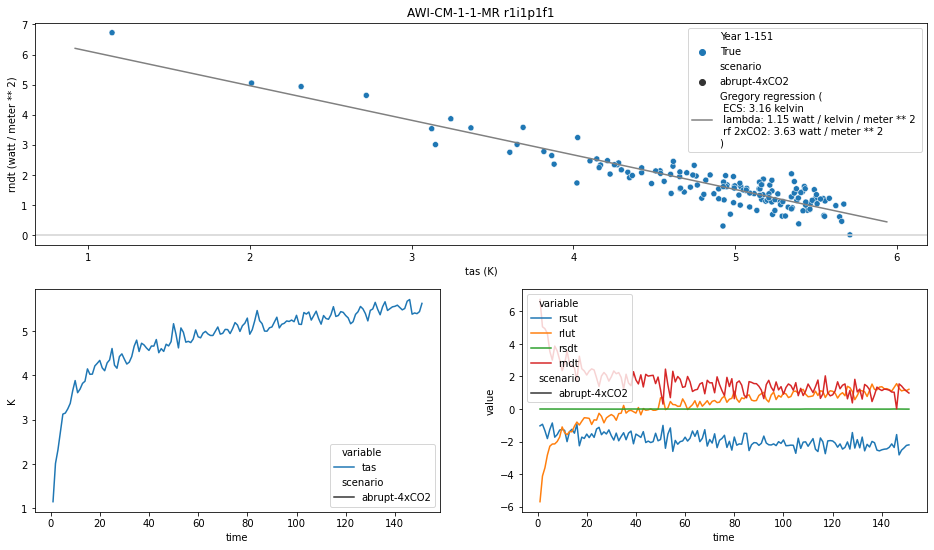

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/BCC/BCC-CSM2-MR/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20181016/**/NORMED*.MAG
set()
Not all data available for BCC-CSM2-MR r1i1p1f1
Missing abrupt-2xCO2


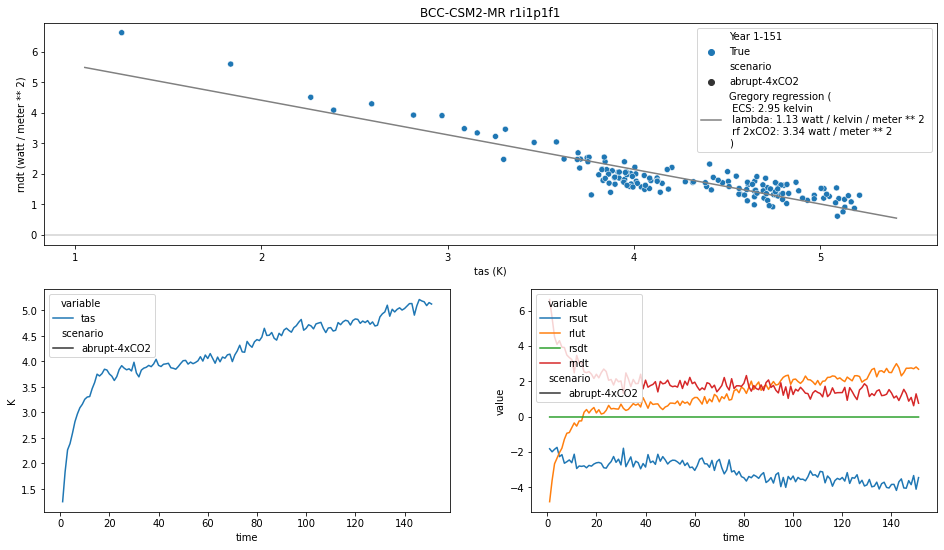

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/BCC/BCC-ESM1/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190613/**/NORMED*.MAG
set()
Not all data available for BCC-ESM1 r1i1p1f1
Missing abrupt-2xCO2


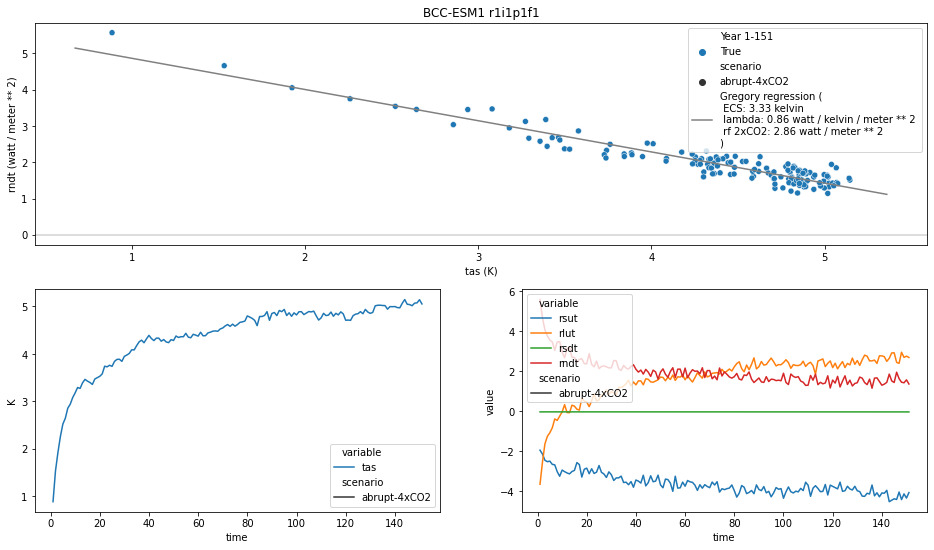

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CAMS/CAMS-CSM1-0/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190708/**/NORMED*.MAG
set()
Not all data available for CAMS-CSM1-0 r1i1p1f1
Missing abrupt-2xCO2


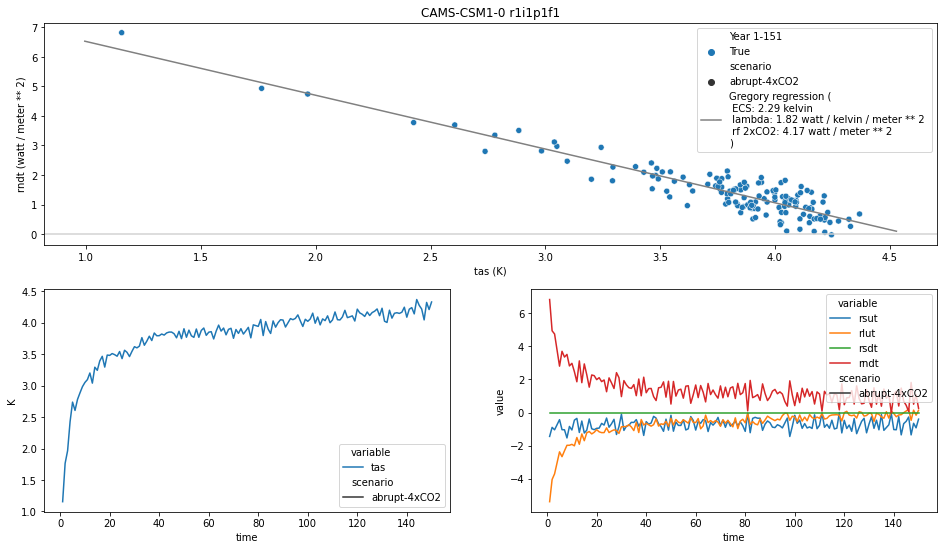

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CAMS/CAMS-CSM1-0/abrupt-2xCO2/r2i1p1f1/Amon/tas/gn/v20190726/**/NORMED*.MAG
set()
Not all data available for CAMS-CSM1-0 r2i1p1f1
Missing abrupt-2xCO2


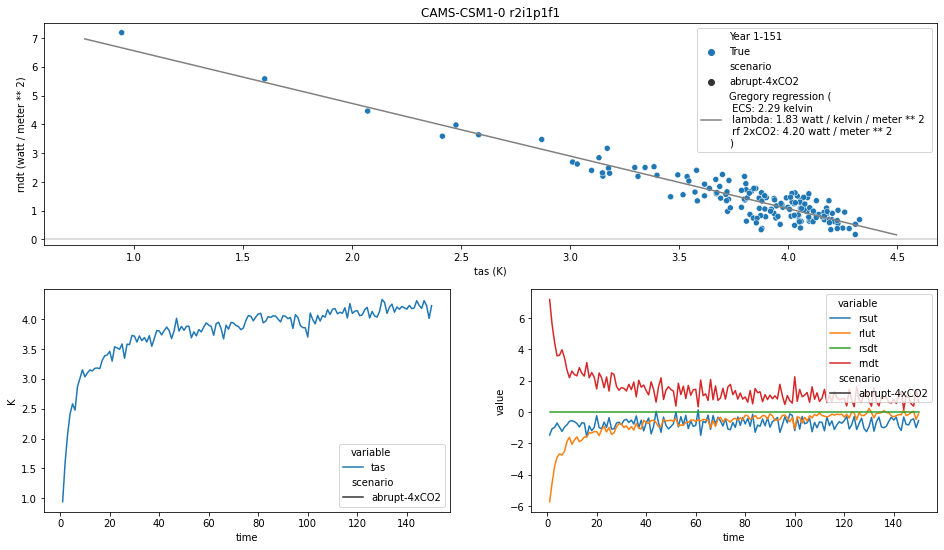

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CAS/FGOALS-g3/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20191230/**/NORMED*.MAG
set()
Not all data available for FGOALS-g3 r1i1p1f1
Missing abrupt-2xCO2


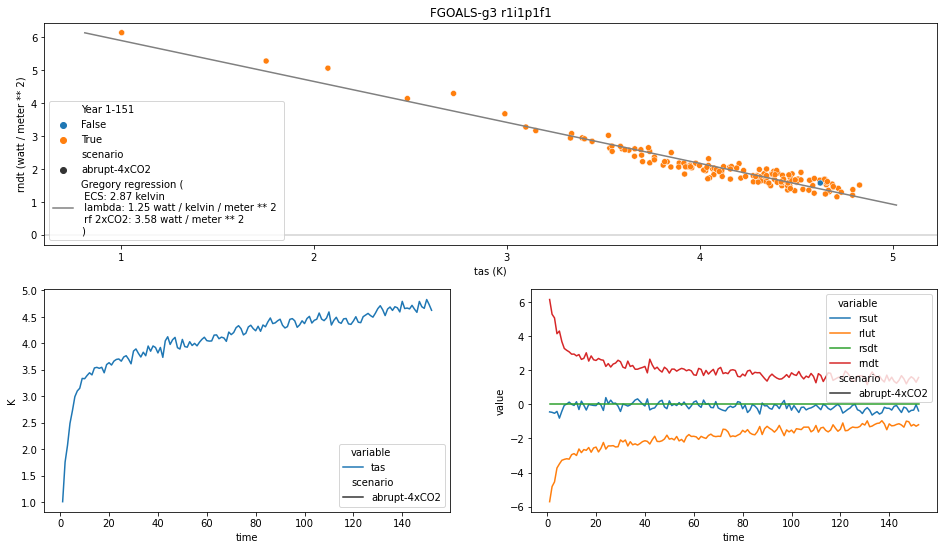

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CCCma/CanESM5/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190429/**/NORMED*.MAG
set()
Not all data available for CanESM5 r1i1p1f1
Missing abrupt-2xCO2


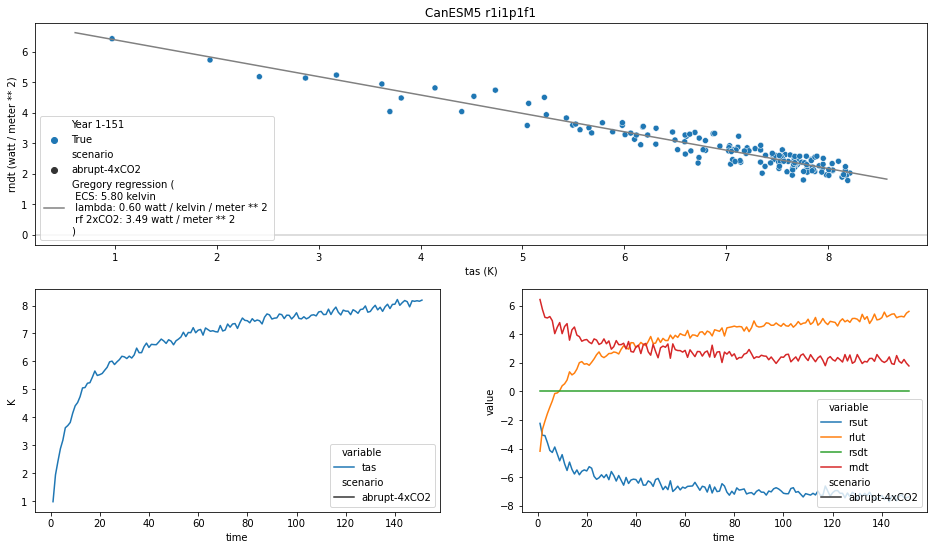

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CCCma/CanESM5/abrupt-2xCO2/r1i1p2f1/Amon/tas/gn/v20190429/**/NORMED*.MAG
set()
Not all data available for CanESM5 r1i1p2f1
Missing abrupt-2xCO2


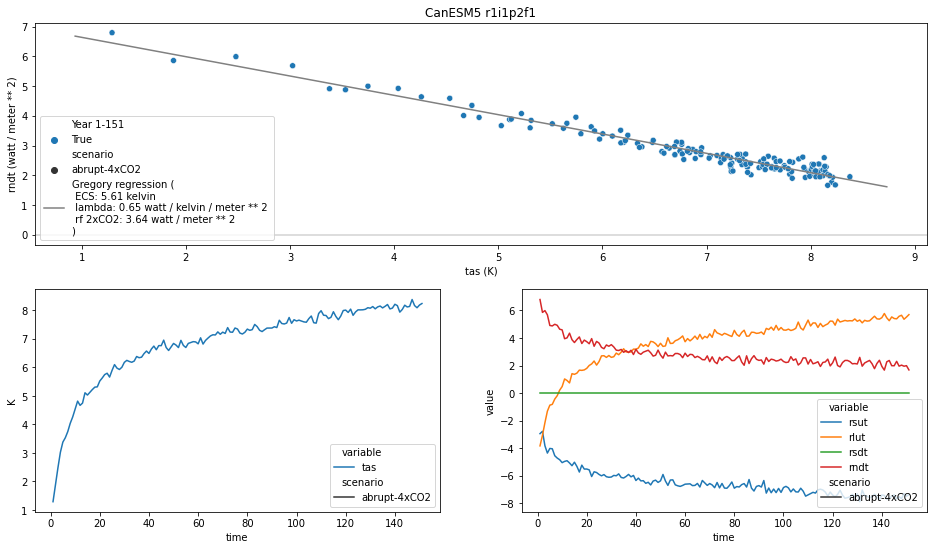

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CMCC/CMCC-CM2-SR5/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20200616/**/NORMED*.MAG
set()
Not all data available for CMCC-CM2-SR5 r1i1p1f1
Missing abrupt-2xCO2


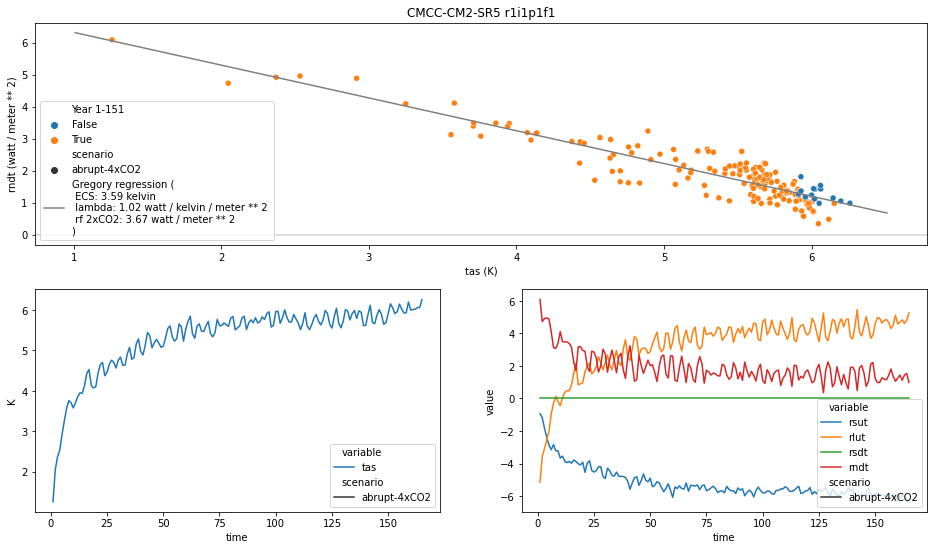

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CNRM-CERFACS/CNRM-CM6-1-HR/abrupt-2xCO2/r1i1p1f2/Amon/tas/gr/v20191021/**/NORMED*.MAG
set()
Not all data available for CNRM-CM6-1-HR r1i1p1f2
Missing abrupt-2xCO2


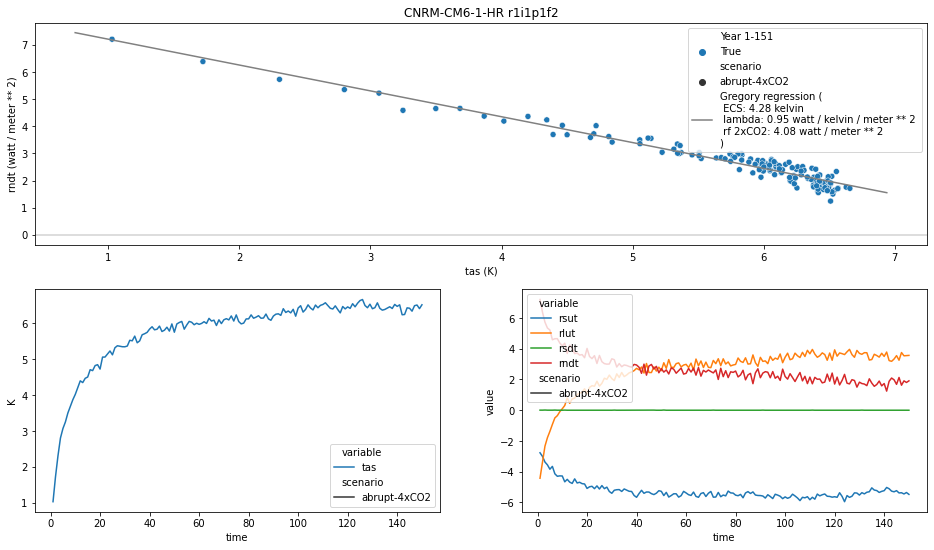

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CNRM-CERFACS/CNRM-CM6-1/abrupt-2xCO2/r1i1p1f2/Amon/tas/gr/v20180705/**/NORMED*.MAG
set()
Not all data available for CNRM-CM6-1 r1i1p1f2
Missing abrupt-2xCO2


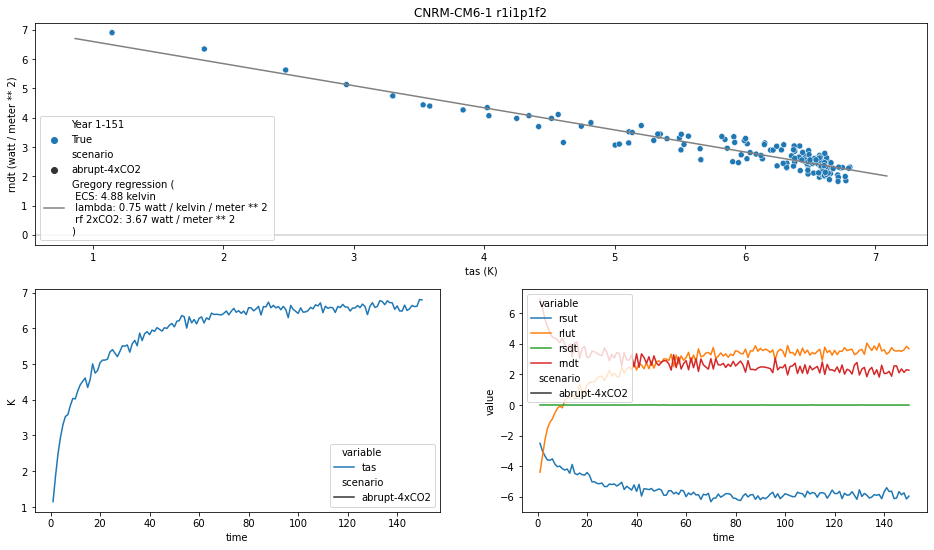

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-2xCO2/r1i1p1f2/Amon/tas/gr/v20181026/**/NORMED*.MAG
set()
Not all data available for CNRM-ESM2-1 r1i1p1f2
Missing abrupt-2xCO2


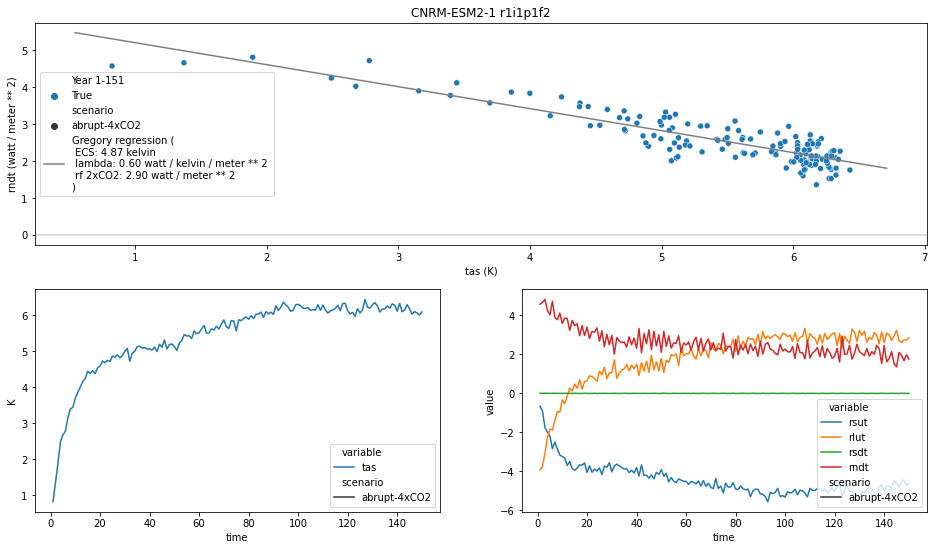

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-2xCO2/r3i1p1f2/Amon/tas/gr/v20190208/**/NORMED*.MAG
set()
Not all data available for CNRM-ESM2-1 r3i1p1f2
Missing abrupt-2xCO2


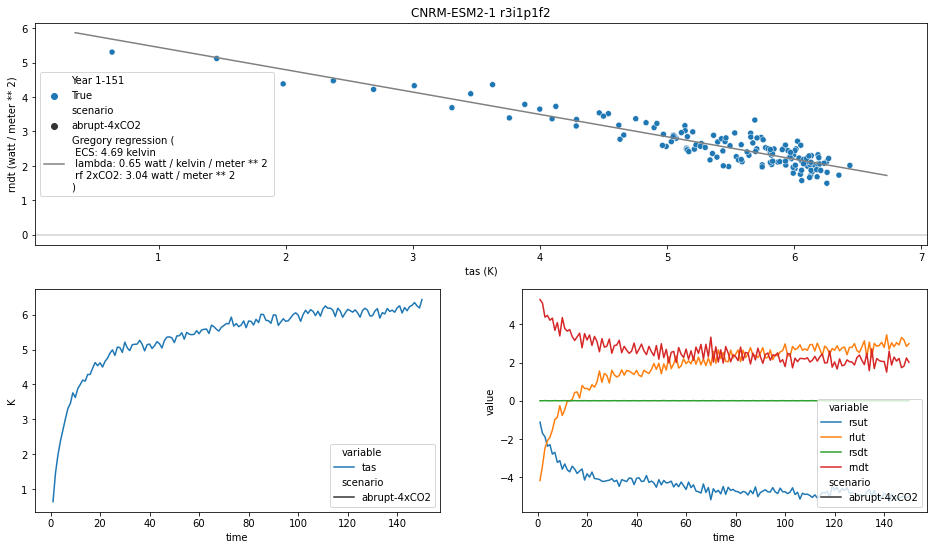

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CSIRO-ARCCSS/ACCESS-CM2/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20191108/**/NORMED*.MAG
set()
Not all data available for ACCESS-CM2 r1i1p1f1
Missing abrupt-2xCO2


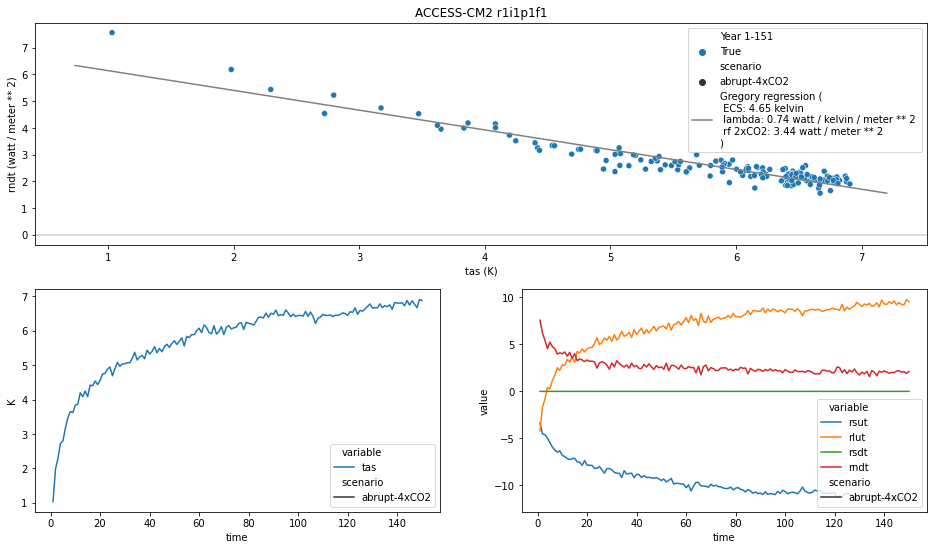

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/CSIRO/ACCESS-ESM1-5/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20191115/**/NORMED*.MAG
set()
Not all data available for ACCESS-ESM1-5 r1i1p1f1
Missing abrupt-2xCO2


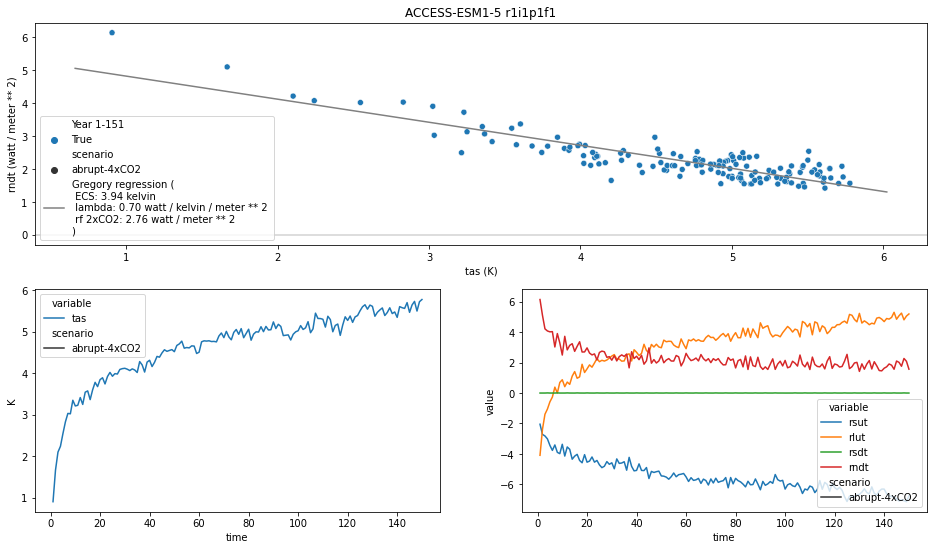

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/E3SM-Project/E3SM-1-0/abrupt-2xCO2/r1i1p1f1/Amon/tas/gr/v20190718/**/NORMED*.MAG
set()
Not all data available for E3SM-1-0 r1i1p1f1
Missing abrupt-2xCO2


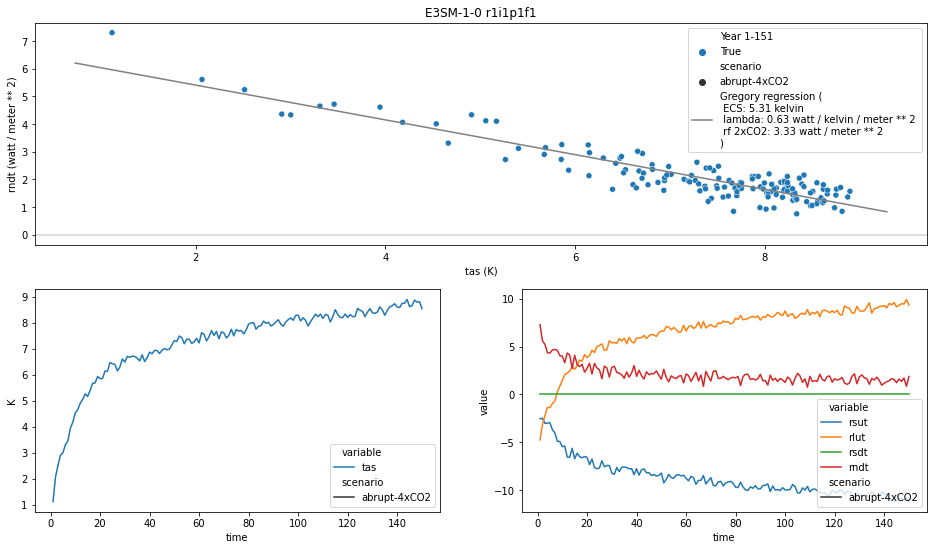

../data/netcdf-scm/average-year-mid-year/CMIP6/CMIP/FIO-QLNM/FIO-ESM-2-0/abrupt-4xCO2/r1i1p1f1/Amon/rsut/gn/v20200302/NORMED*.MAG
Not all data available for FIO-ESM-2-0 r1i1p1f1
Missing rsut
Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/FIO-QLNM/FIO-ESM-2-0/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20200302/**/NORMED*.MAG
set()
Not all data available for FIO-ESM-2-0 r1i1p1f1
Missing abrupt-2xCO2
../data/netcdf-scm/average-year-mid-year/CMIP6/CMIP/FIO-QLNM/FIO-ESM-2-0/abrupt-4xCO2/r2i1p1f1/Amon/rsut/gn/v20200302/NORMED*.MAG
Not all data available for FIO-ESM-2-0 r2i1p1f1
Missing rsut
Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/FIO-QLNM/FIO-ESM-2-0/abrupt-2xCO2/r2i1p1f1/Amon/tas/gn/v20200302/**/NORMED*.MAG
set()
Not all data available for FIO-ESM-2-0 r2i1p1f1
Missing abrupt-2xCO2
../data/netcdf-scm/average-year-mid-year/CMIP6/CMIP/FIO-QLNM/FIO-ESM-2-0/abrupt-4xCO2/r3i1p1f1/Amon/rsut/gn/v20200302/NORMED*.MAG
Not all data avail

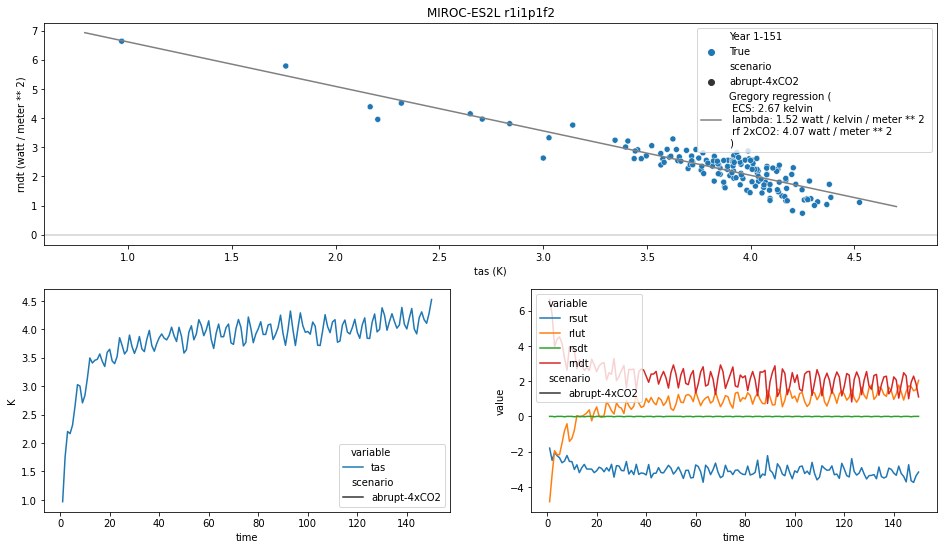

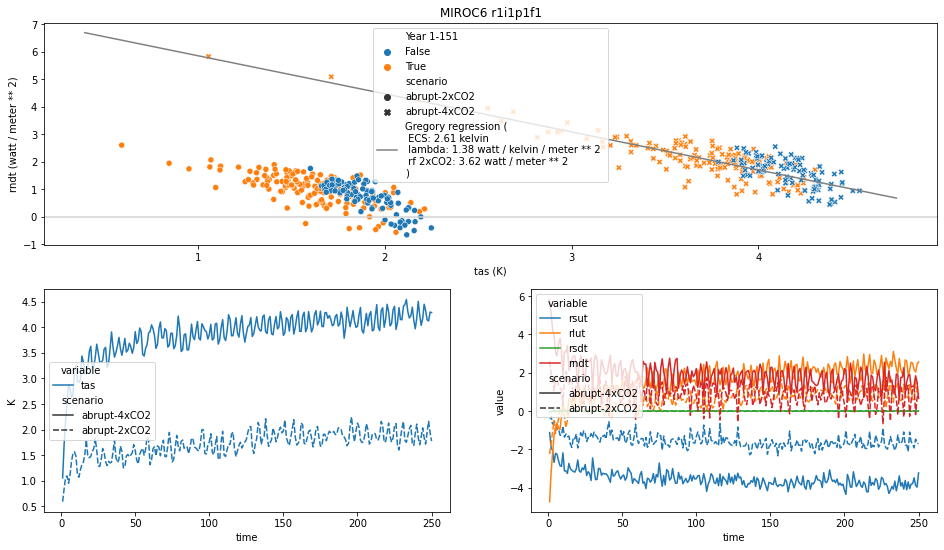

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MOHC/HadGEM3-GC31-LL/abrupt-2xCO2/r1i1p1f3/Amon/tas/gn/v20190620/**/NORMED*.MAG
set()
Not all data available for HadGEM3-GC31-LL r1i1p1f3
Missing abrupt-2xCO2


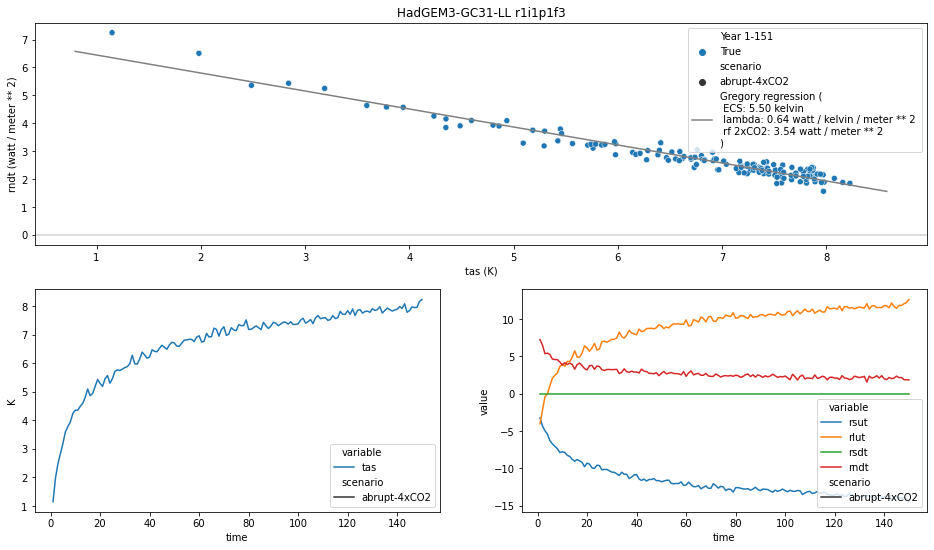

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MOHC/HadGEM3-GC31-MM/abrupt-2xCO2/r1i1p1f3/Amon/tas/gn/v20200115/**/NORMED*.MAG
set()
Not all data available for HadGEM3-GC31-MM r1i1p1f3
Missing abrupt-2xCO2


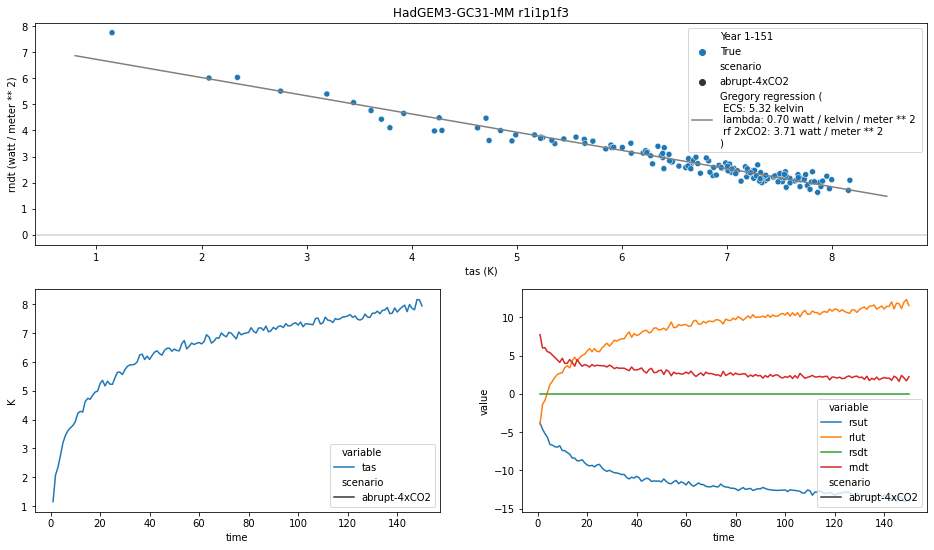

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MPI-M/MPI-ESM1-2-HR/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190710/**/NORMED*.MAG
set()
Not all data available for MPI-ESM1-2-HR r1i1p1f1
Missing abrupt-2xCO2


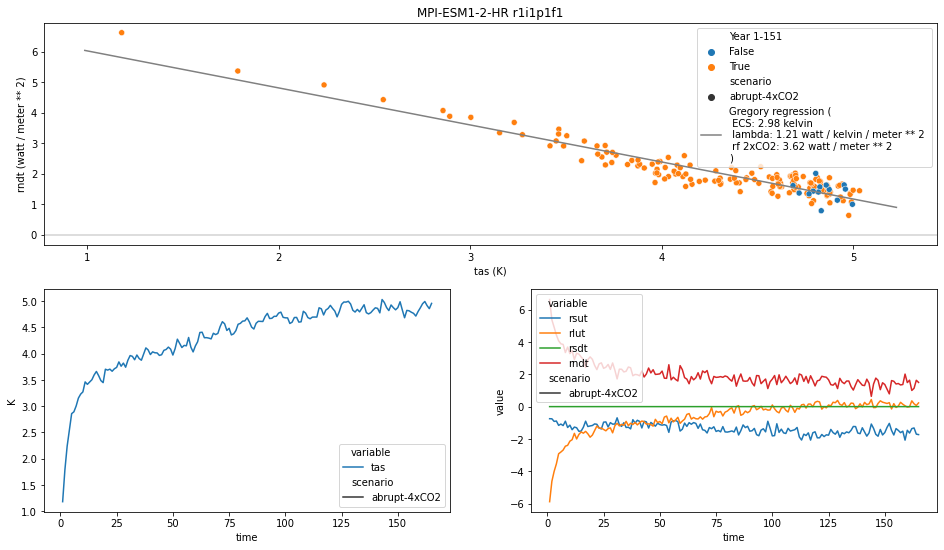

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MPI-M/MPI-ESM1-2-LR/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190710/**/NORMED*.MAG
set()
Not all data available for MPI-ESM1-2-LR r1i1p1f1
Missing abrupt-2xCO2


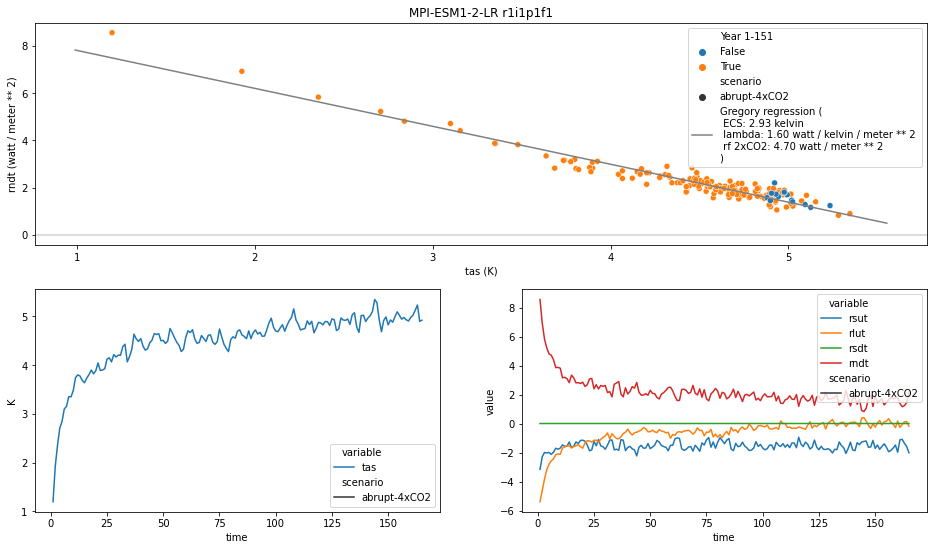

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MRI/MRI-ESM2-0/abrupt-2xCO2/r10i1p1f1/Amon/tas/gn/v20190308/**/NORMED*.MAG
set()
Not all data available for MRI-ESM2-0 r10i1p1f1
Missing abrupt-2xCO2


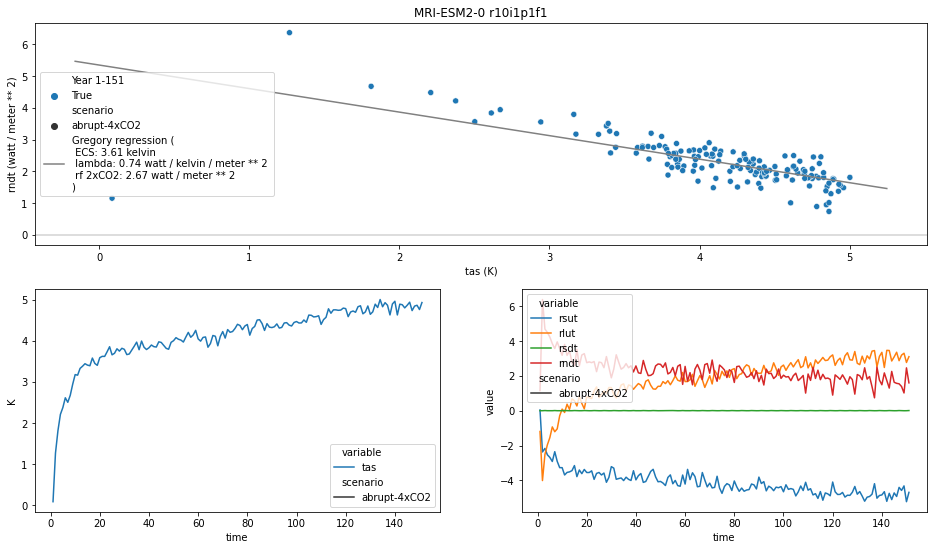

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MRI/MRI-ESM2-0/abrupt-2xCO2/r13i1p1f1/Amon/tas/gn/v20190308/**/NORMED*.MAG
set()
Not all data available for MRI-ESM2-0 r13i1p1f1
Missing abrupt-2xCO2


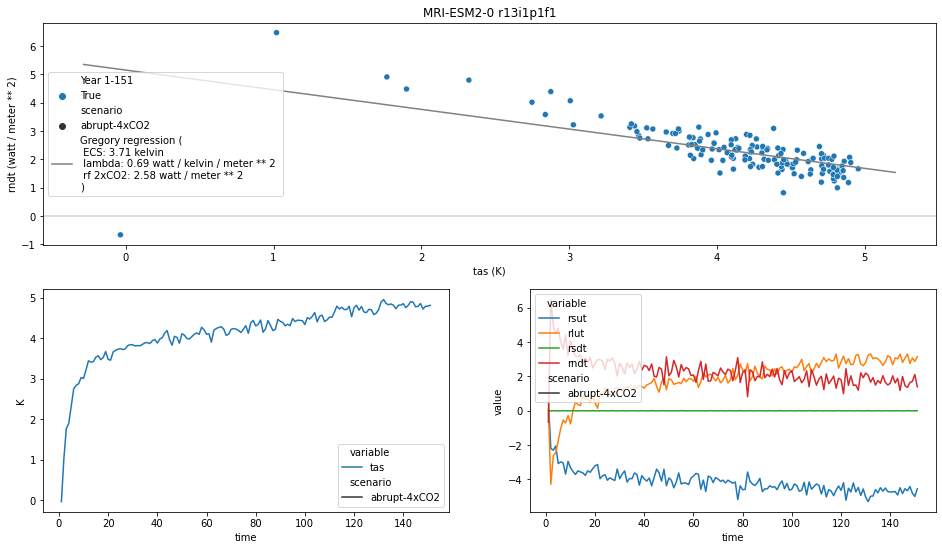

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MRI/MRI-ESM2-0/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190308/**/NORMED*.MAG
set()
Not all data available for MRI-ESM2-0 r1i1p1f1
Missing abrupt-2xCO2


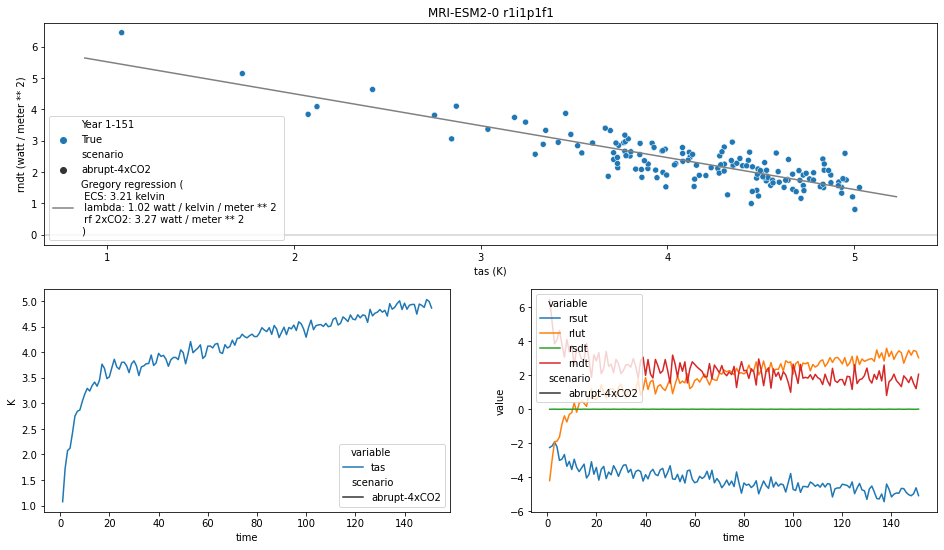

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MRI/MRI-ESM2-0/abrupt-2xCO2/r1i2p1f1/Amon/tas/gn/v20191205/**/NORMED*.MAG
set()
Not all data available for MRI-ESM2-0 r1i2p1f1
Missing abrupt-2xCO2


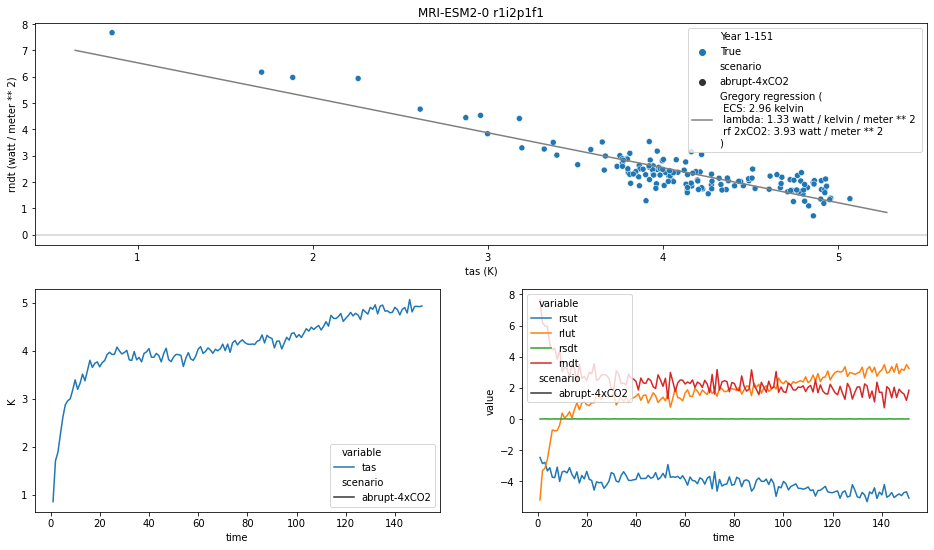

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MRI/MRI-ESM2-0/abrupt-2xCO2/r4i1p1f1/Amon/tas/gn/v20190308/**/NORMED*.MAG
set()
Not all data available for MRI-ESM2-0 r4i1p1f1
Missing abrupt-2xCO2


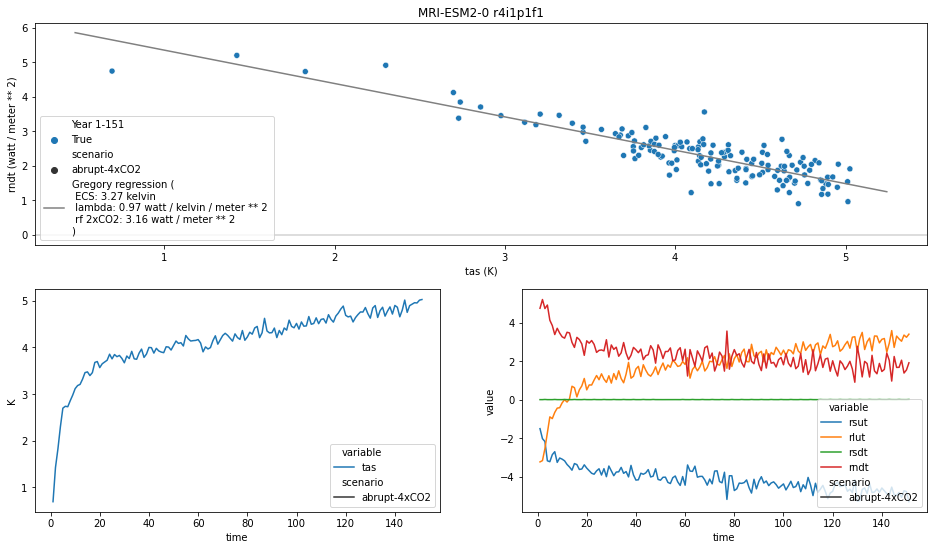

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/MRI/MRI-ESM2-0/abrupt-2xCO2/r7i1p1f1/Amon/tas/gn/v20190308/**/NORMED*.MAG
set()
Not all data available for MRI-ESM2-0 r7i1p1f1
Missing abrupt-2xCO2


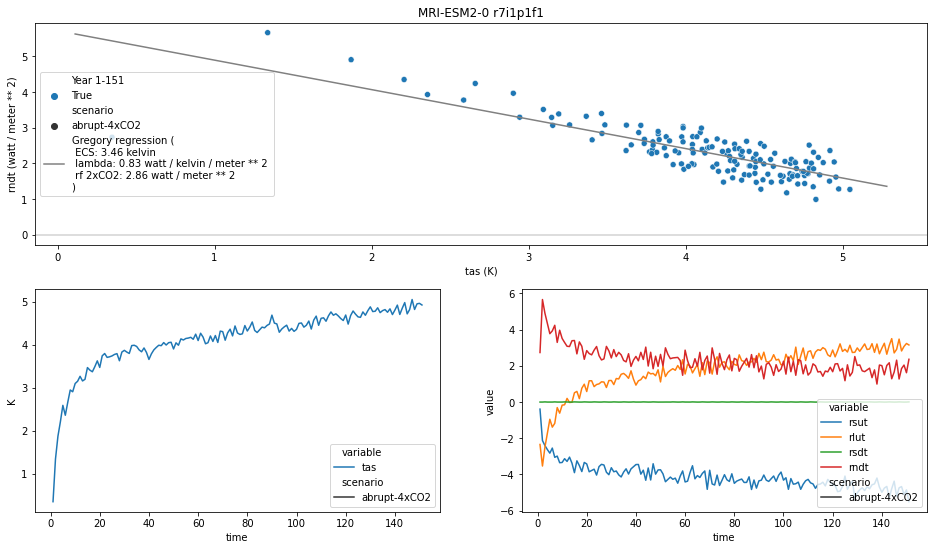

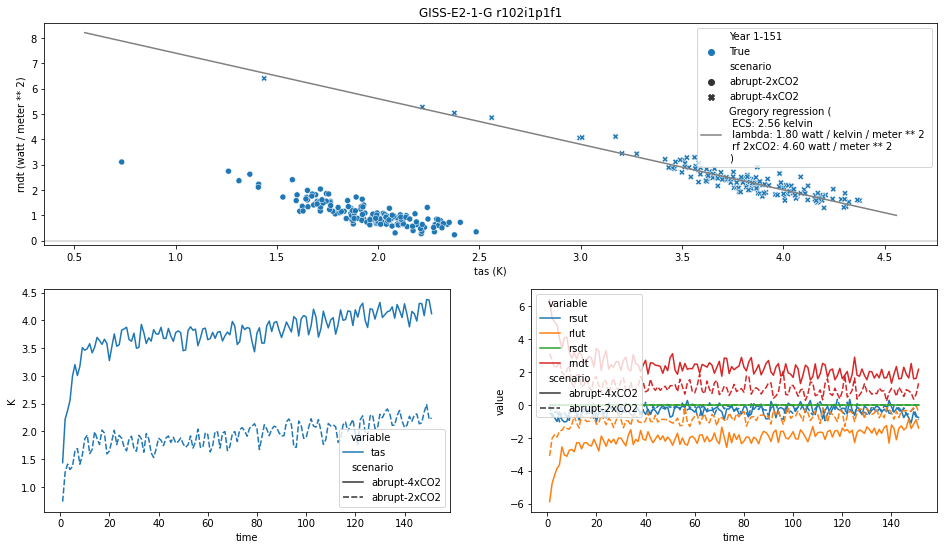

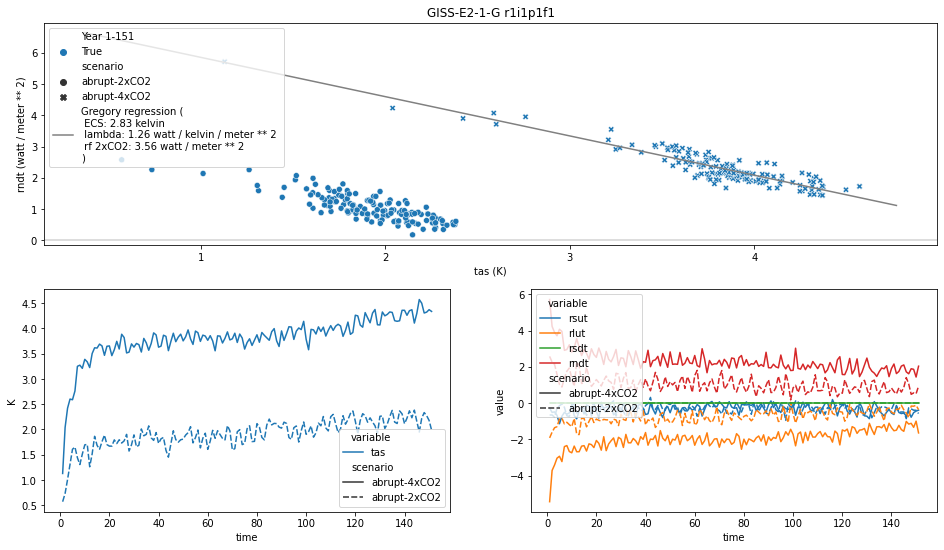

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/NASA-GISS/GISS-E2-1-G/abrupt-2xCO2/r1i1p1f3/Amon/tas/gn/v20190916/**/NORMED*.MAG
set()
Not all data available for GISS-E2-1-G r1i1p1f3
Missing abrupt-2xCO2


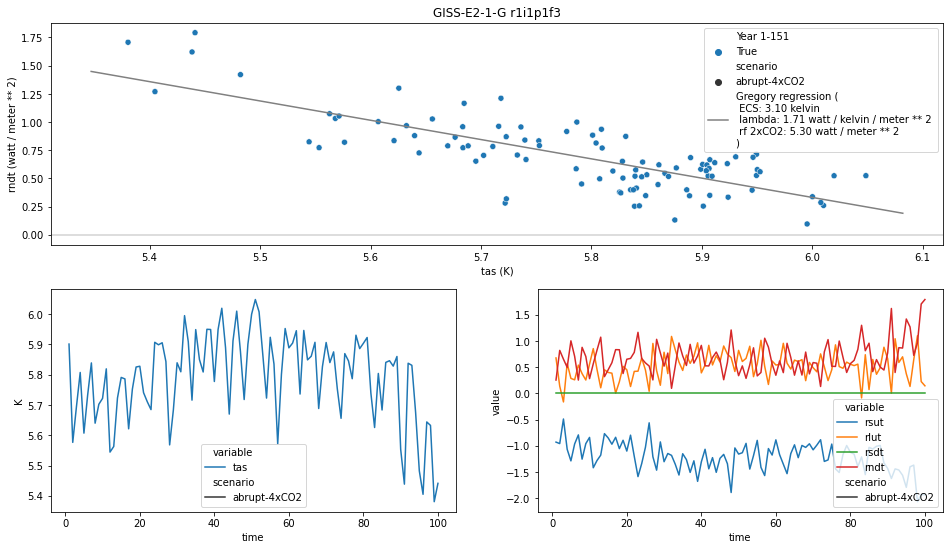

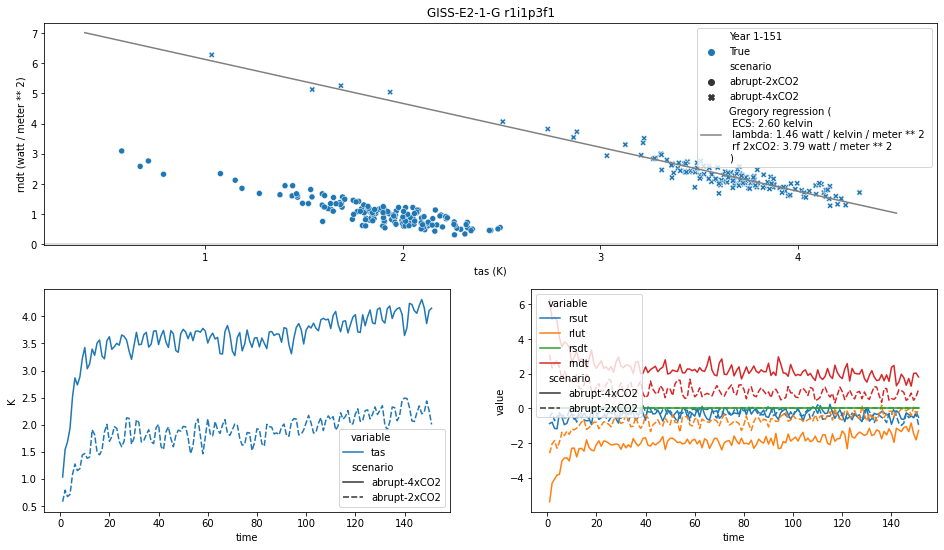

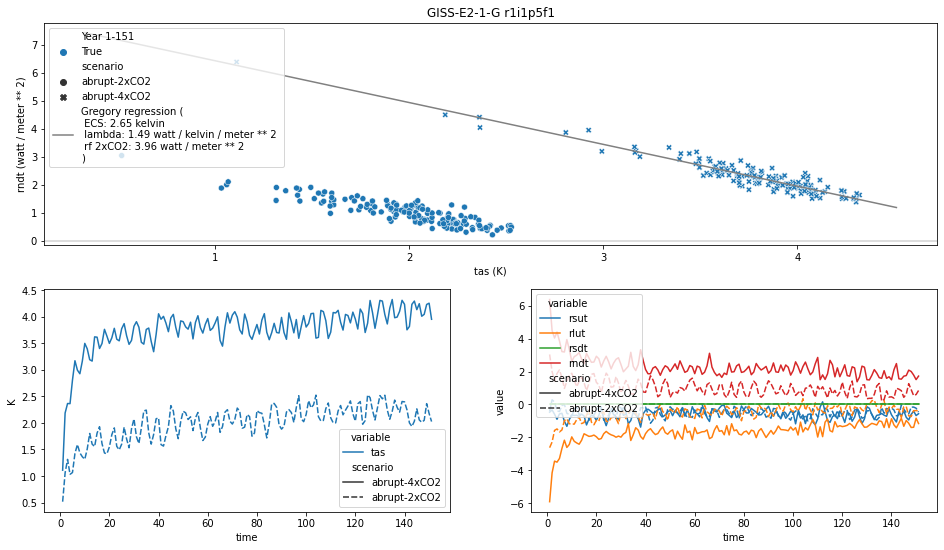

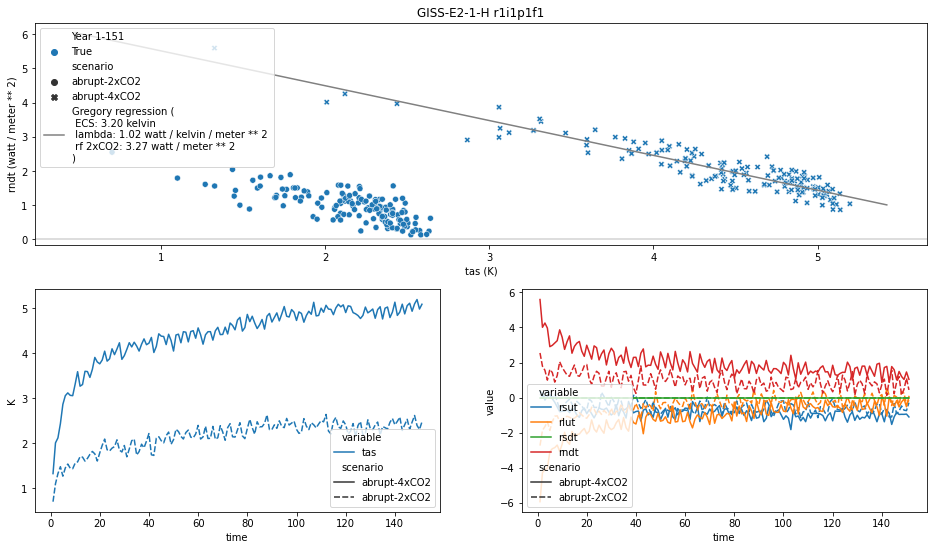

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/NASA-GISS/GISS-E2-1-H/abrupt-2xCO2/r1i1p3f1/Amon/tas/gn/v20191010/**/NORMED*.MAG
set()
Not all data available for GISS-E2-1-H r1i1p3f1
Missing abrupt-2xCO2


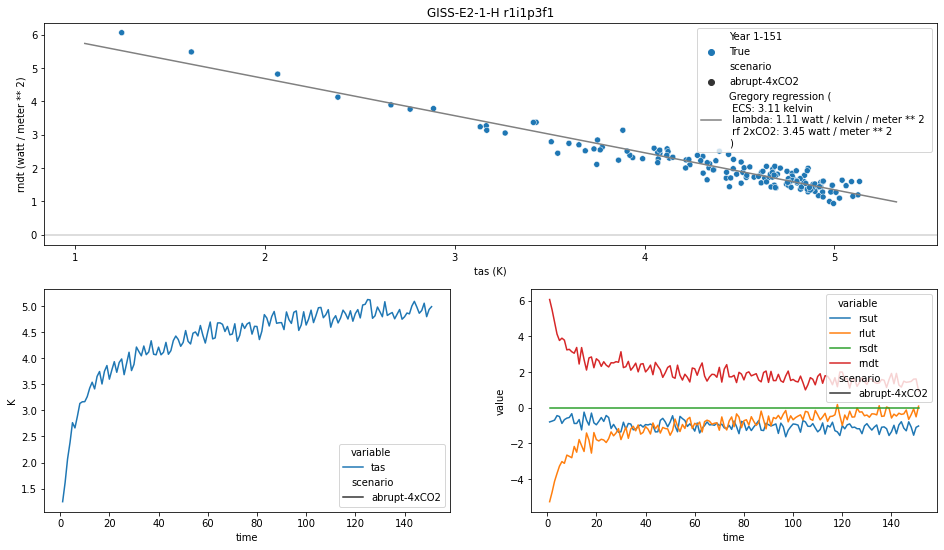

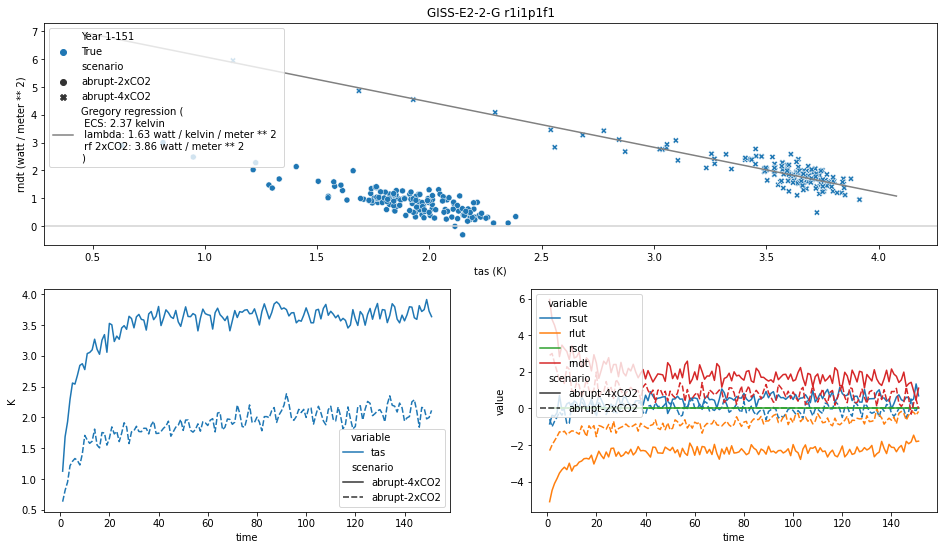

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/NCAR/CESM2-FV2/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20200403/**/NORMED*.MAG
set()
Not all data available for CESM2-FV2 r1i1p1f1
Missing abrupt-2xCO2


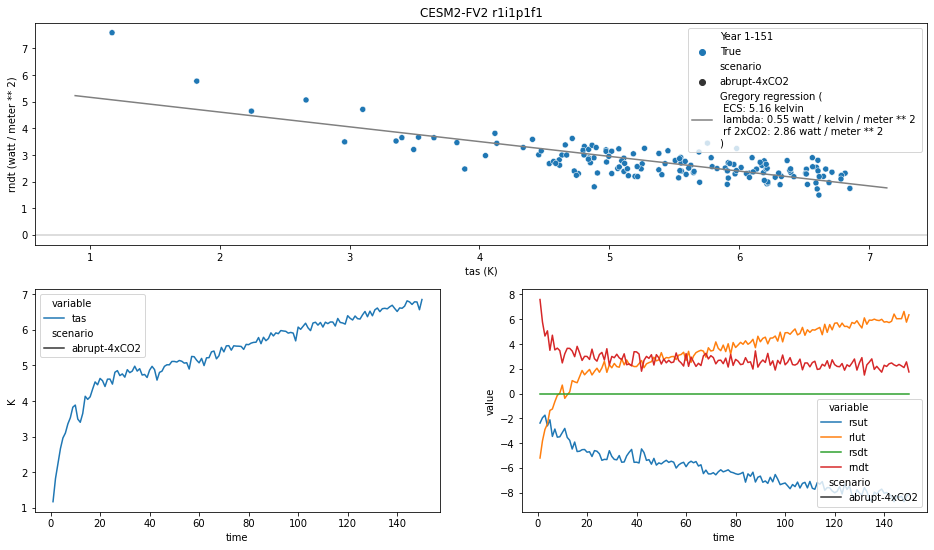

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/NCAR/CESM2-WACCM-FV2/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20200403/**/NORMED*.MAG
set()
Not all data available for CESM2-WACCM-FV2 r1i1p1f1
Missing abrupt-2xCO2


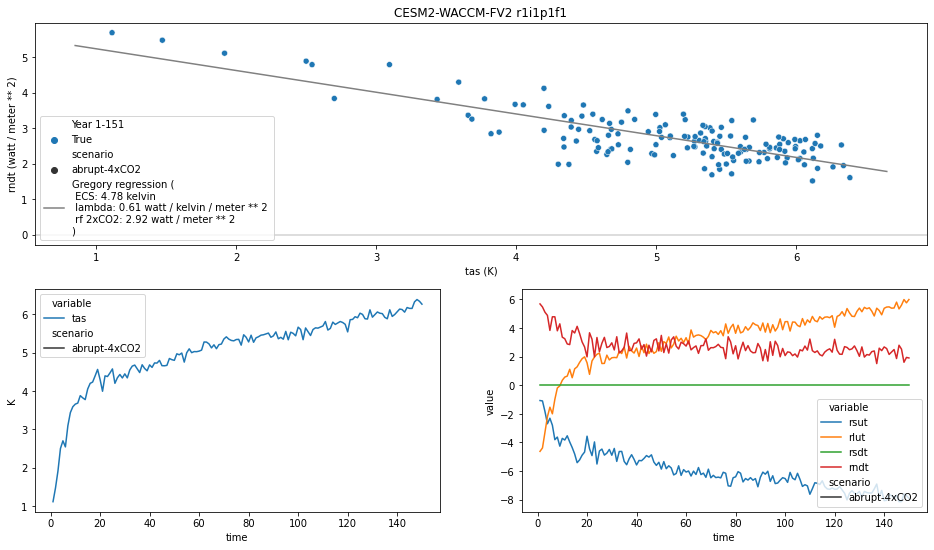

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/NCAR/CESM2-WACCM/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190425/**/NORMED*.MAG
set()
Not all data available for CESM2-WACCM r1i1p1f1
Missing abrupt-2xCO2


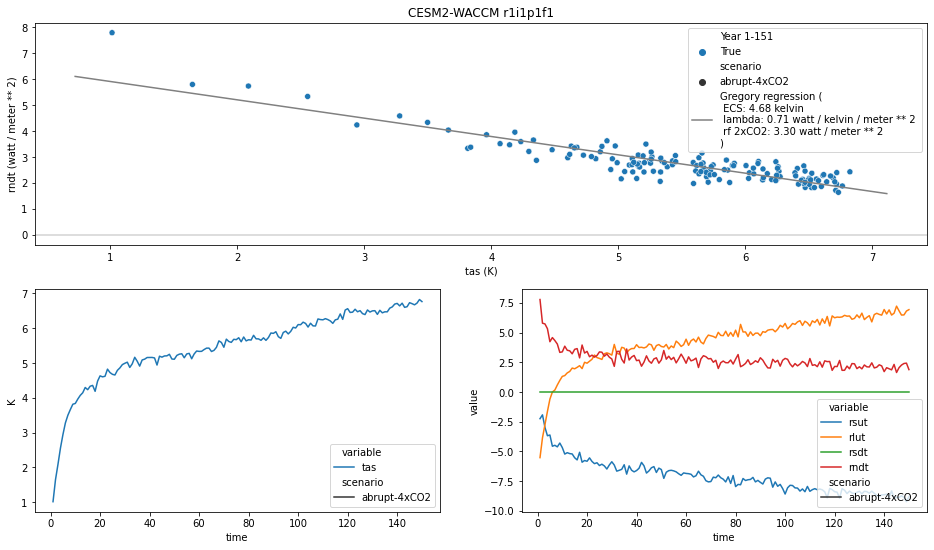

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/NCC/NorCPM1/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190914/**/NORMED*.MAG
set()
Not all data available for NorCPM1 r1i1p1f1
Missing abrupt-2xCO2


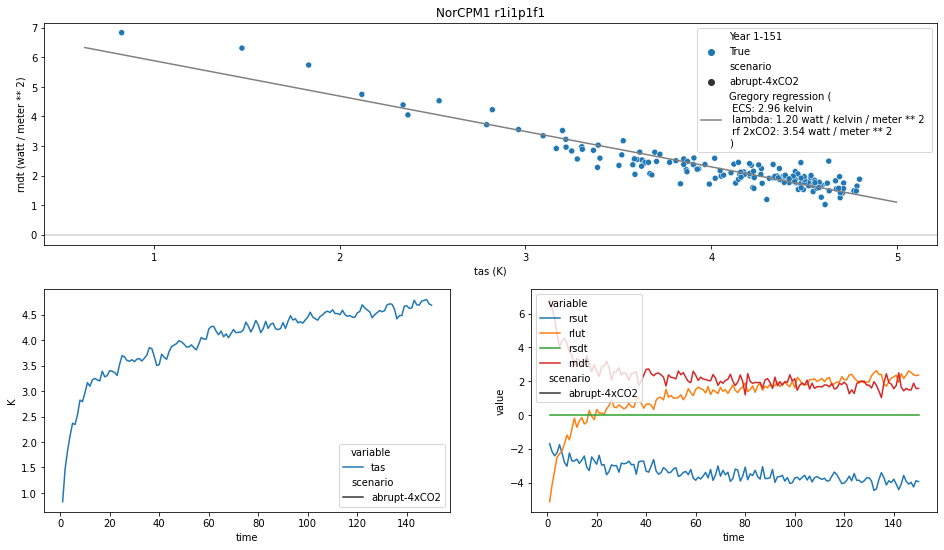

Not all data available for ../data/netcdf-scm/average-year-mid-year/CMIP6/CFMIP/SNU/SAM0-UNICON/abrupt-2xCO2/r1i1p1f1/Amon/tas/gn/v20190323/**/NORMED*.MAG
set()
Not all data available for SAM0-UNICON r1i1p1f1
Missing abrupt-2xCO2


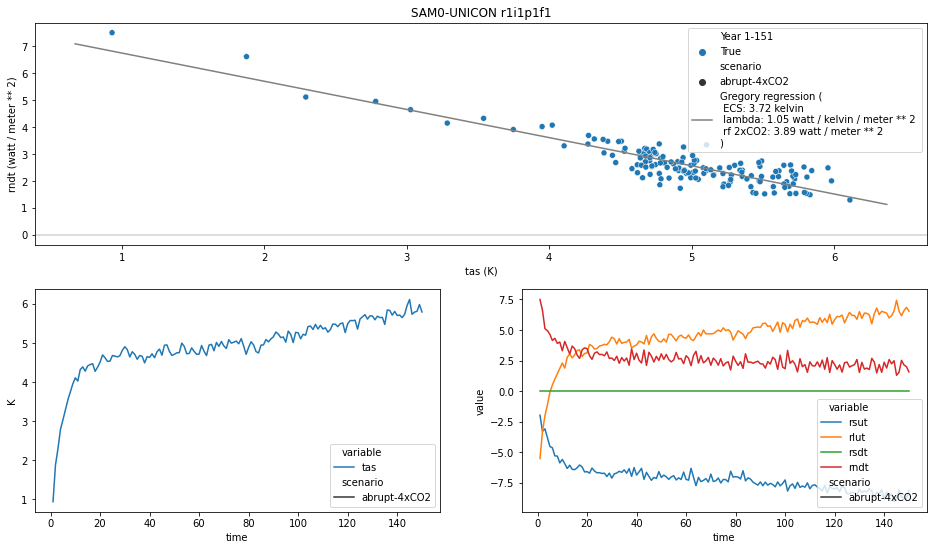

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/ACCESS1-0/r1i1p1/**/NORMED*.MAG
set()
Not all data available for ACCESS1-0 r1i1p1
Missing abrupt-2xCO2


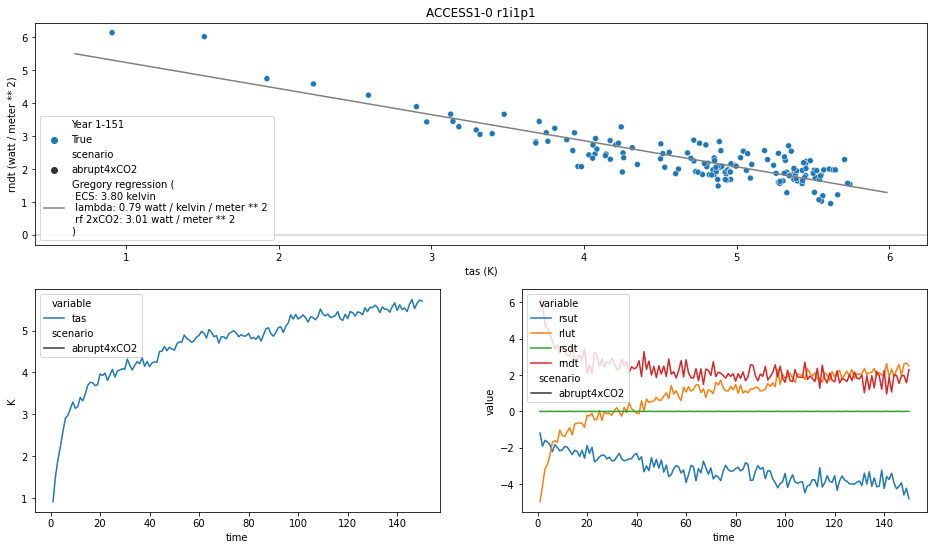

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/ACCESS1-3/r1i1p1/**/NORMED*.MAG
set()
Not all data available for ACCESS1-3 r1i1p1
Missing abrupt-2xCO2


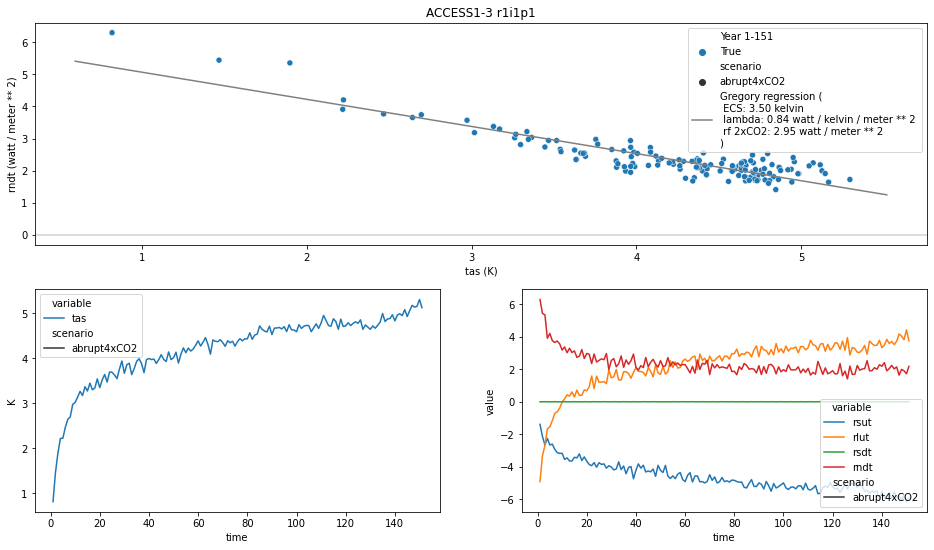

../data/netcdf-scm/average-year-mid-year/cmip5/abrupt4xCO2/Amon/rsdt/BNU-ESM/r1i1p1/NORMED*.MAG
Not all data available for BNU-ESM r1i1p1
Missing rsdt
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/BNU-ESM/r1i1p1/**/NORMED*.MAG
set()
Not all data available for BNU-ESM r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CNRM-CM5/r1i1p1/**/NORMED*.MAG
set()
Not all data available for CNRM-CM5 r1i1p1
Missing abrupt-2xCO2


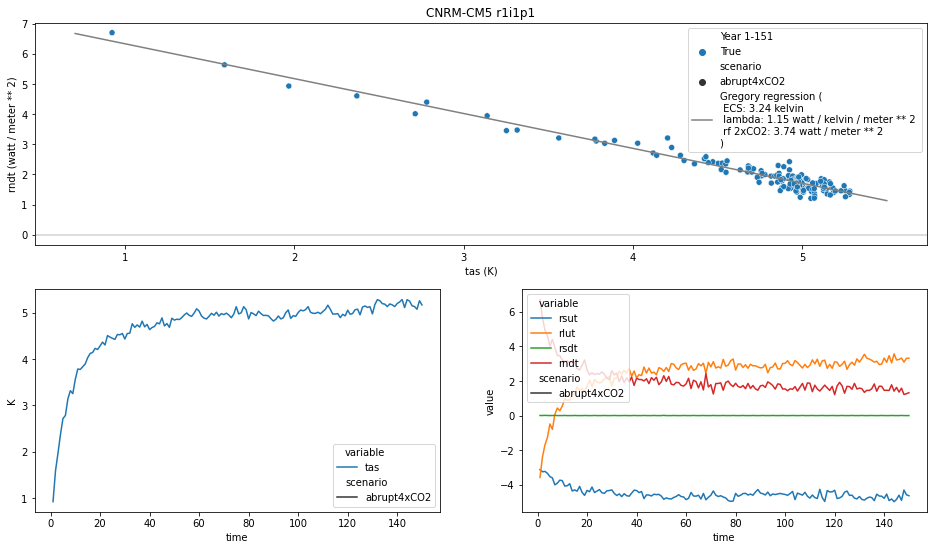

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CSIRO-Mk3-6-0/r1i1p1/**/NORMED*.MAG
set()
Not all data available for CSIRO-Mk3-6-0 r1i1p1
Missing abrupt-2xCO2


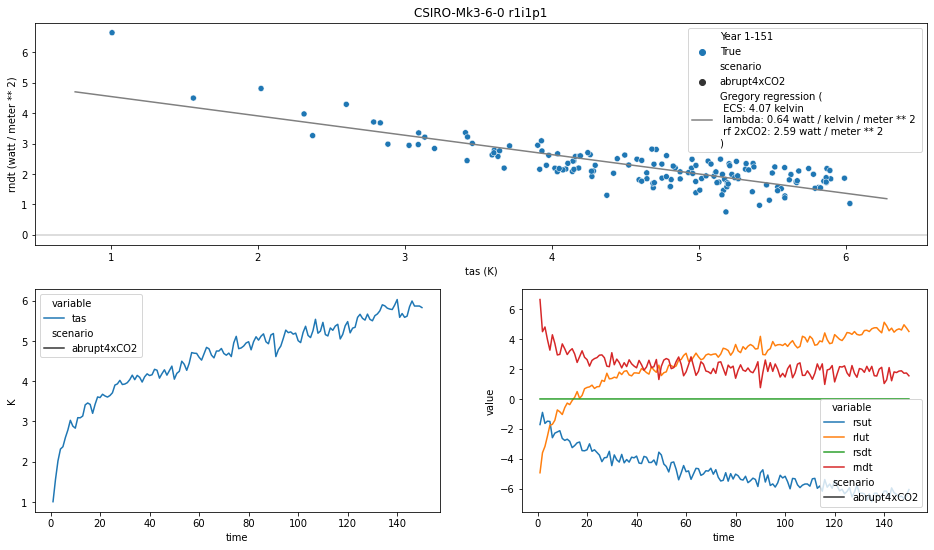

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r10i1p1/**/NORMED*.MAG
set()
Not all data available for CSIRO-Mk3-6-0 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r11i1p1/**/NORMED*.MAG
set()
Not all data available for CSIRO-Mk3-6-0 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r12i1p1/**/NORMED*.MAG
set()
Not all data available for CSIRO-Mk3-6-0 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r1i1p1/**/NORMED*.MAG
set()
Not all data available for CanESM2 r1i1p1
Missing abrupt-2xCO2


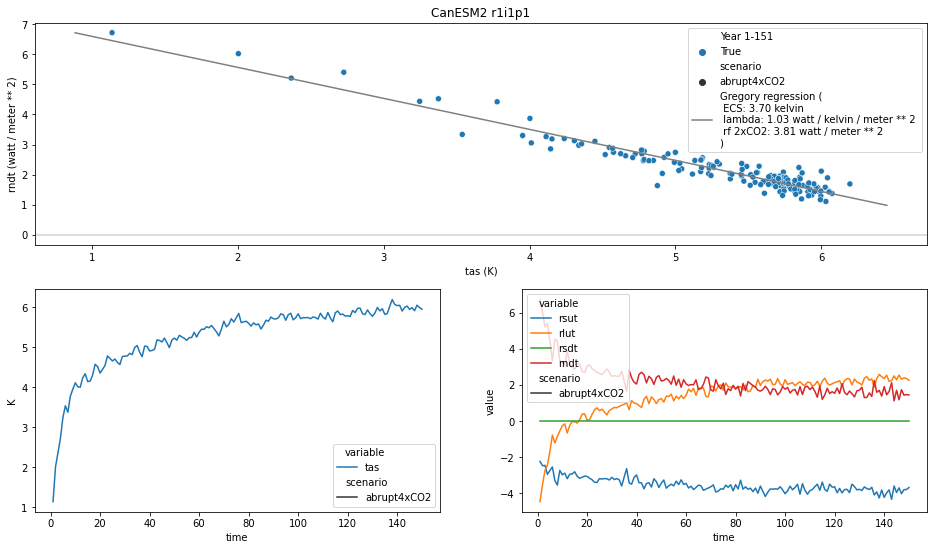

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r2i1p1/**/NORMED*.MAG
set()
Not all data available for CanESM2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r3i1p1/**/NORMED*.MAG
set()
Not all data available for CanESM2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r4i1p1/**/NORMED*.MAG
set()
Not all data available for CanESM2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r5i1p1/**/NORMED*.MAG
set()
Not all data available for CanESM2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/CanESM2/r6i1p1/**/NORMED*.MAG
set()
Not all data available for CanESM2 r1i1p1
Missing abrupt-2xCO2
Not all data available fo

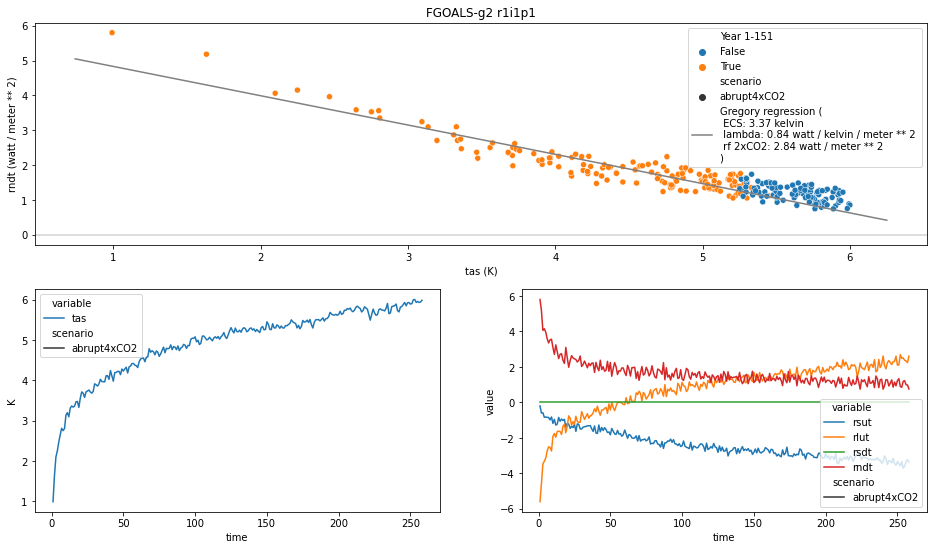

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/FGOALS-g2/r2i1p1/**/NORMED*.MAG
set()
Not all data available for FGOALS-g2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/FGOALS-g2/r3i1p1/**/NORMED*.MAG
set()
Not all data available for FGOALS-g2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/FGOALS-g2/r4i1p1/**/NORMED*.MAG
set()
Not all data available for FGOALS-g2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/FGOALS-g2/r5i1p1/**/NORMED*.MAG
set()
Not all data available for FGOALS-g2 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/FGOALS-g2/r6i1p1/**/NORMED*.MAG
set()
Not all data available for FGOALS-g2 r1i1p1
Missing abrupt-2xCO2
Not a

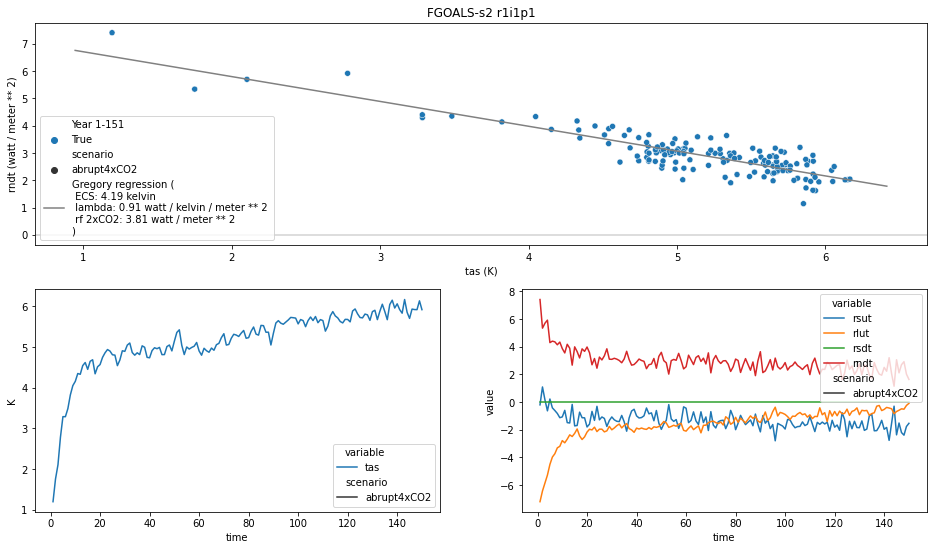

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/GISS-E2-H/r1i1p2/**/NORMED*.MAG
set()
Not all data available for GISS-E2-H r1i1p2
Missing abrupt-2xCO2


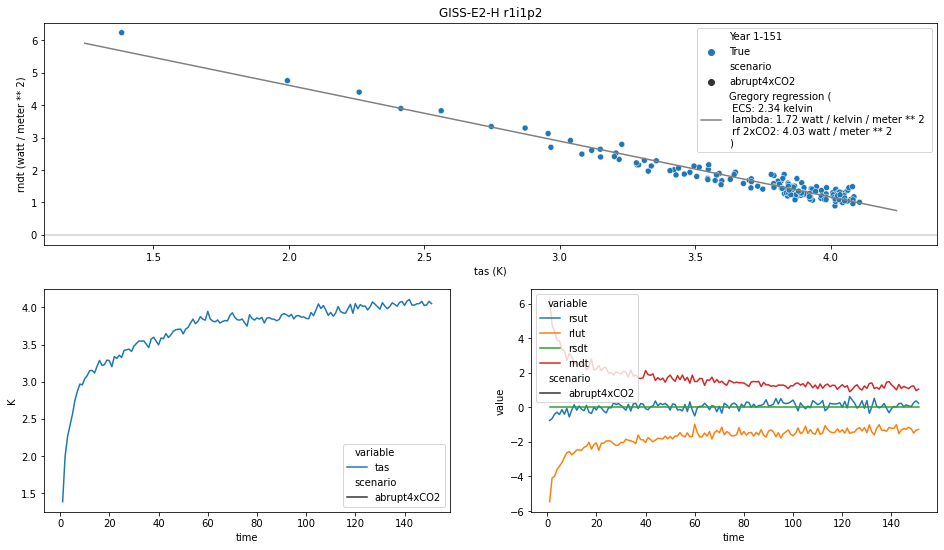

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/GISS-E2-H/r1i1p3/**/NORMED*.MAG
set()
Not all data available for GISS-E2-H r1i1p3
Missing abrupt-2xCO2


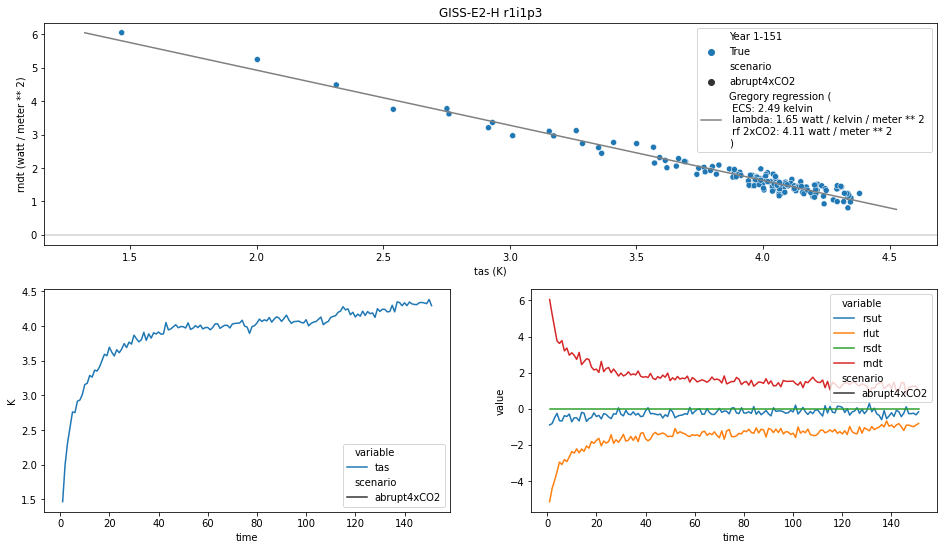

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/GISS-E2-R/r1i1p2/**/NORMED*.MAG
set()
Not all data available for GISS-E2-R r1i1p2
Missing abrupt-2xCO2


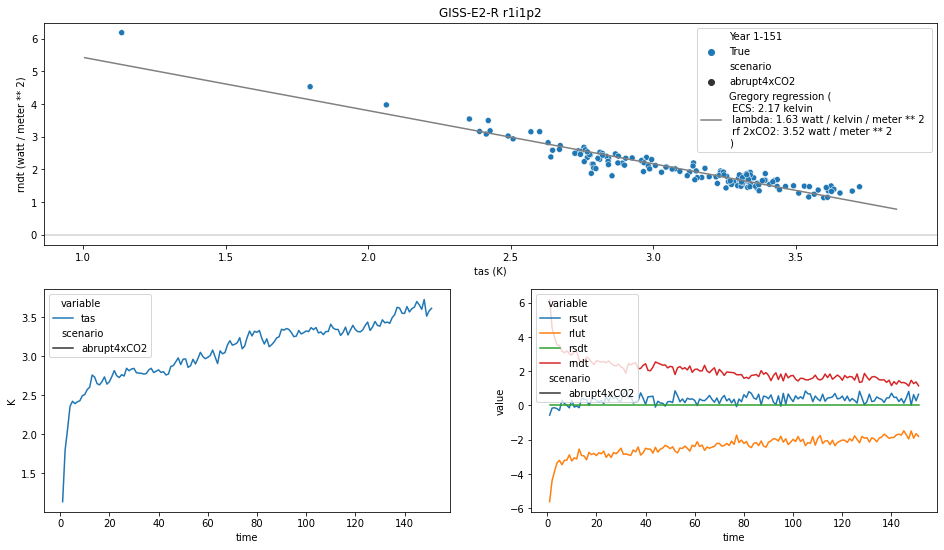

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/GISS-E2-R/r1i1p3/**/NORMED*.MAG
set()
Not all data available for GISS-E2-R r1i1p3
Missing abrupt-2xCO2


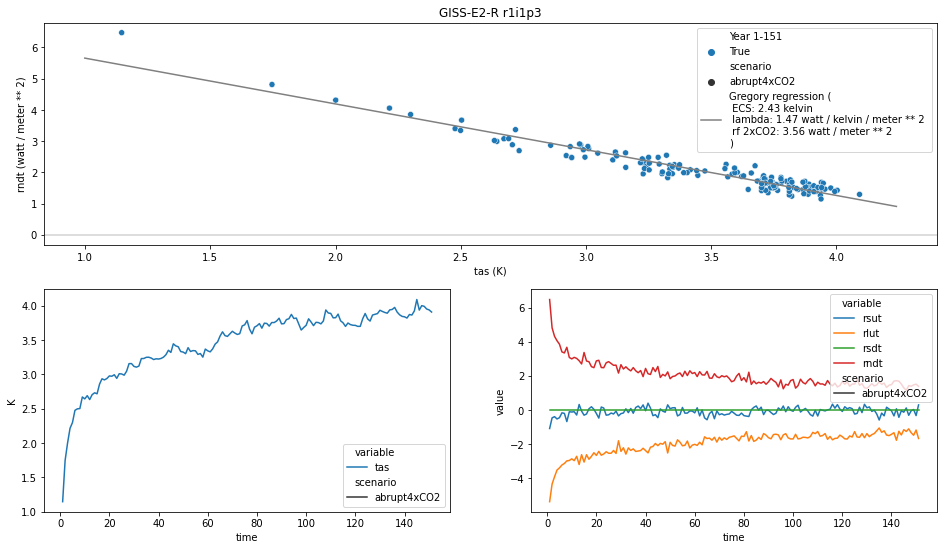

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r10i1p1/**/NORMED*.MAG
set()
Not all data available for GISS-E2-R r1i1p3
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r11i1p1/**/NORMED*.MAG
set()
Not all data available for GISS-E2-R r1i1p3
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r12i1p1/**/NORMED*.MAG
set()
Not all data available for GISS-E2-R r1i1p3
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r1i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5A-LR r1i1p1
Missing abrupt-2xCO2


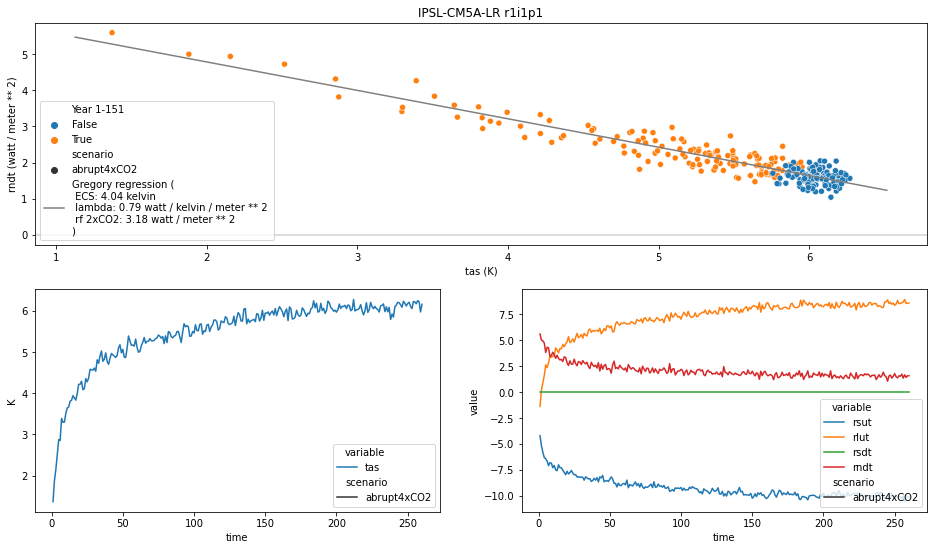

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r2i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5A-LR r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r3i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5A-LR r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r4i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5A-LR r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r5i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5A-LR r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5A-LR/r6i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5A-LR r1i

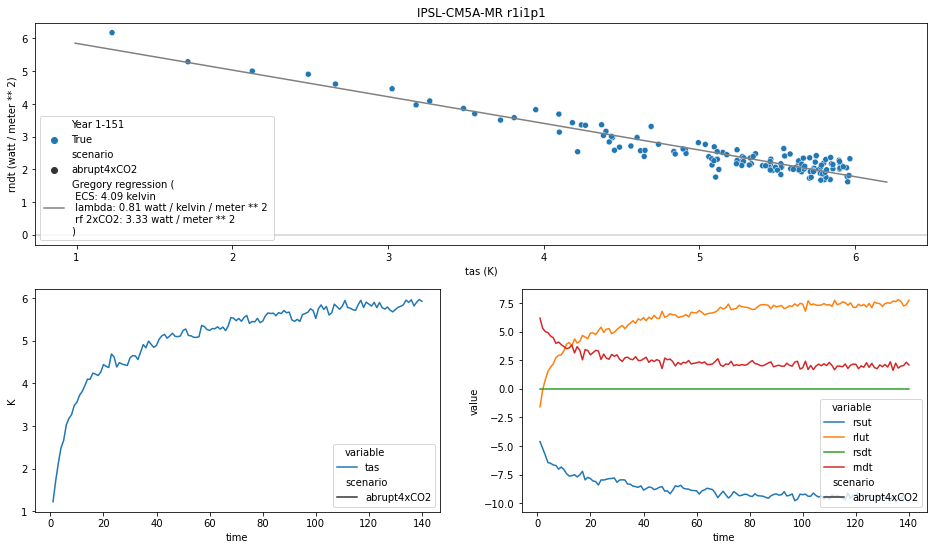

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/IPSL-CM5B-LR/r1i1p1/**/NORMED*.MAG
set()
Not all data available for IPSL-CM5B-LR r1i1p1
Missing abrupt-2xCO2


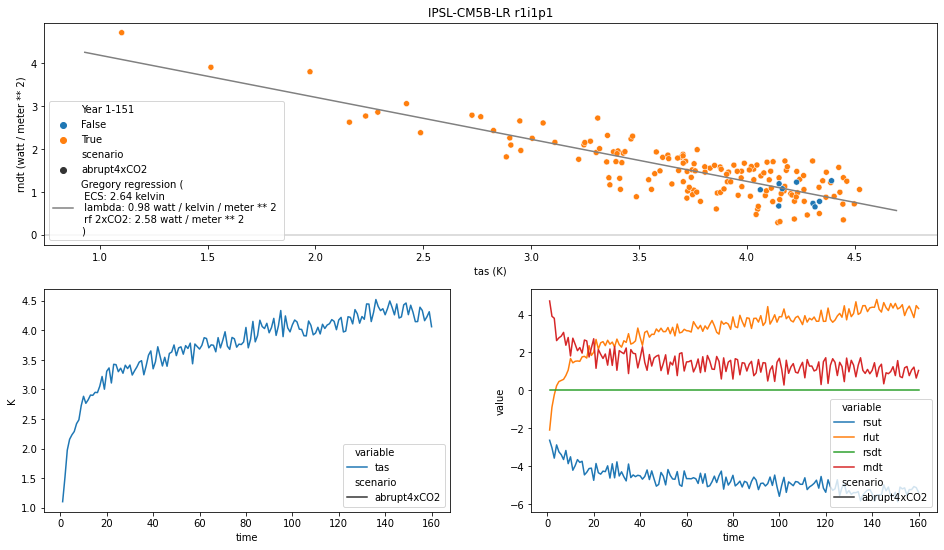

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC-ESM/r1i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC-ESM r1i1p1
Missing abrupt-2xCO2


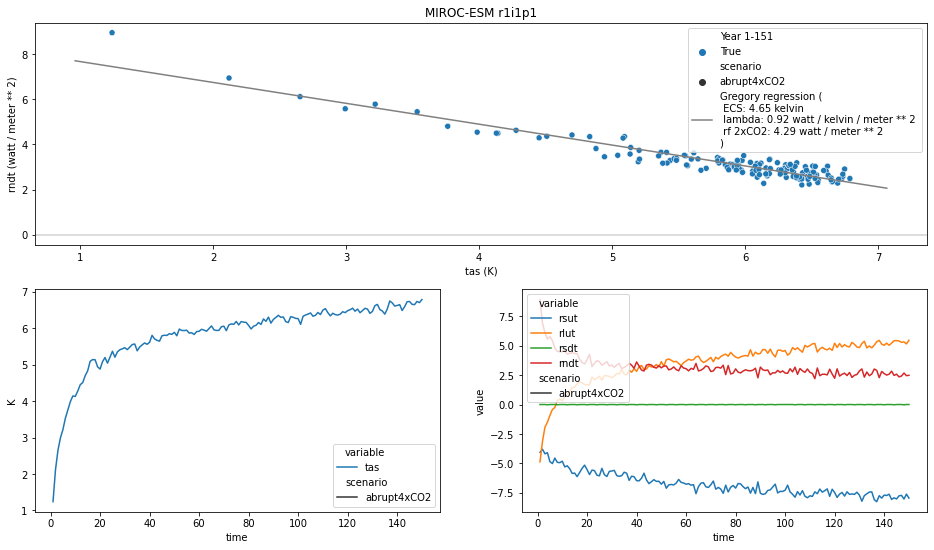

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r10i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC-ESM r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r11i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC-ESM r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r12i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC-ESM r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r1i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC5 r1i1p1
Missing abrupt-2xCO2


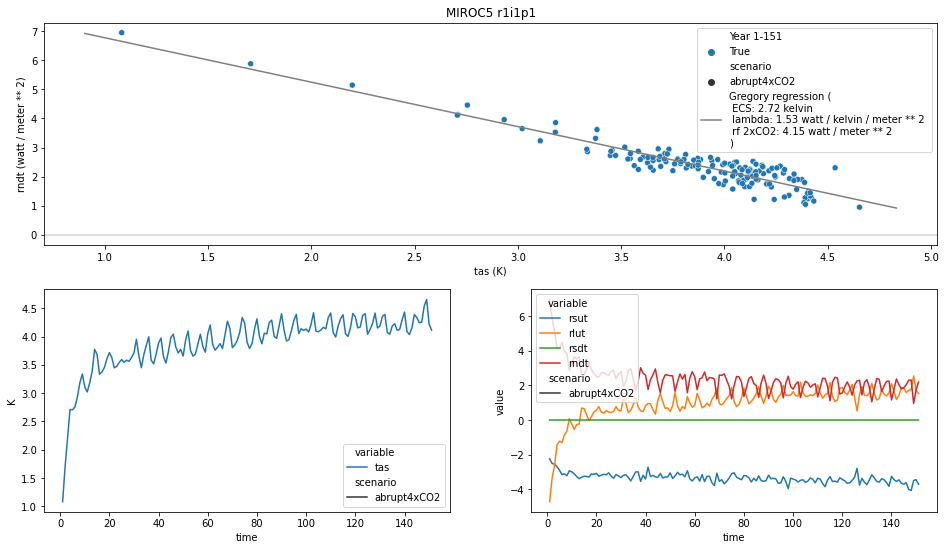

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r2i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC5 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r3i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC5 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r4i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC5 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r5i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC5 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MIROC5/r6i1p1/**/NORMED*.MAG
set()
Not all data available for MIROC5 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/

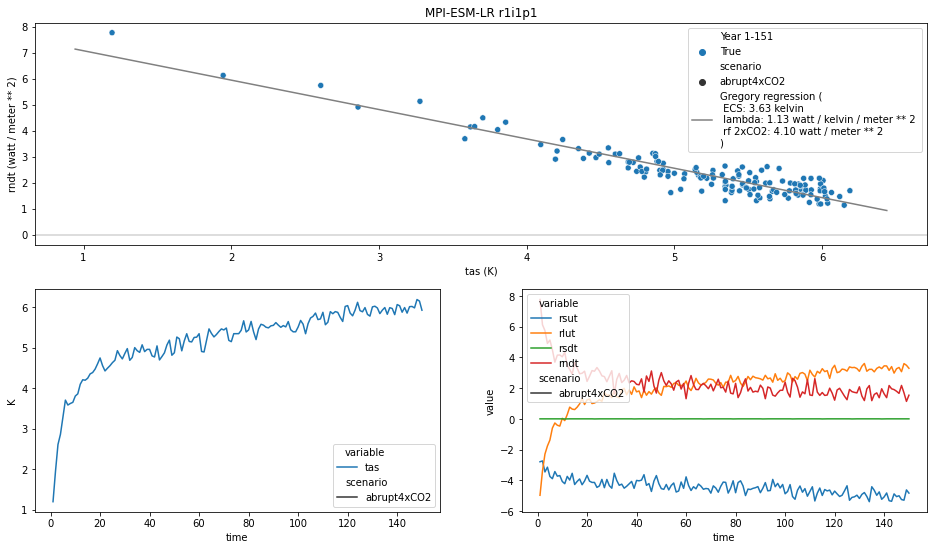

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MPI-ESM-MR/r1i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-MR r1i1p1
Missing abrupt-2xCO2


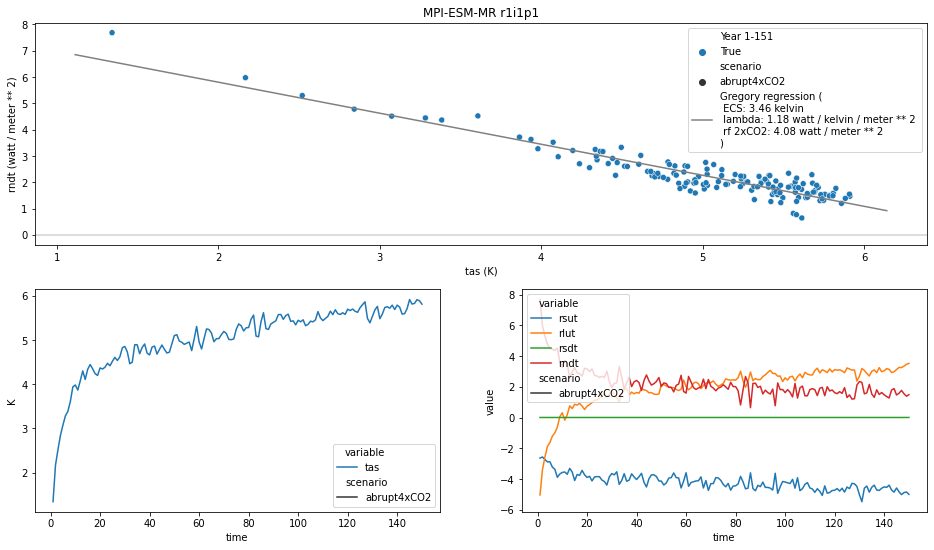

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MPI-ESM-P/r1i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-P r1i1p1
Missing abrupt-2xCO2


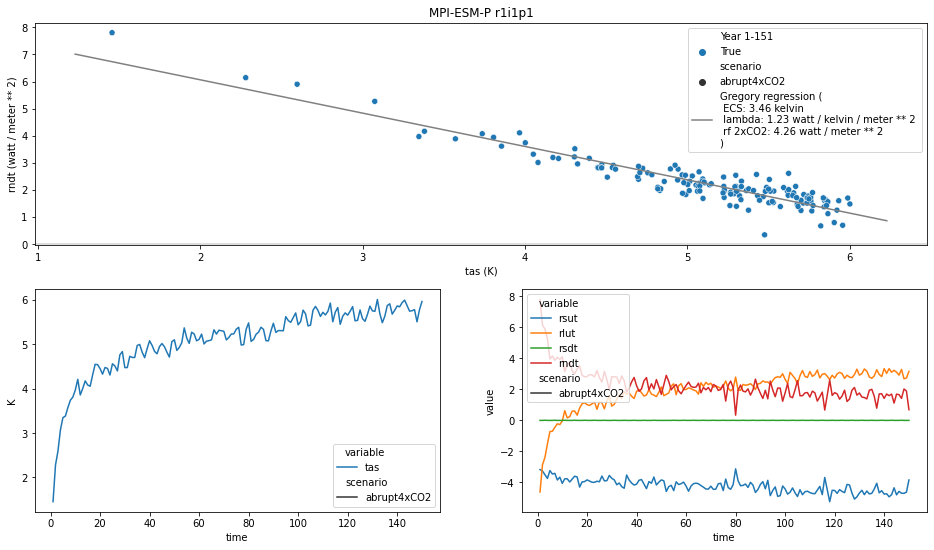

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r10i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-P r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r11i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-P r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r12i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-P r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r13i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-P r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r14i1p1/**/NORMED*.MAG
set()
Not all data available for MPI-ESM-P r1i1p1
Missing abrupt-2xCO2


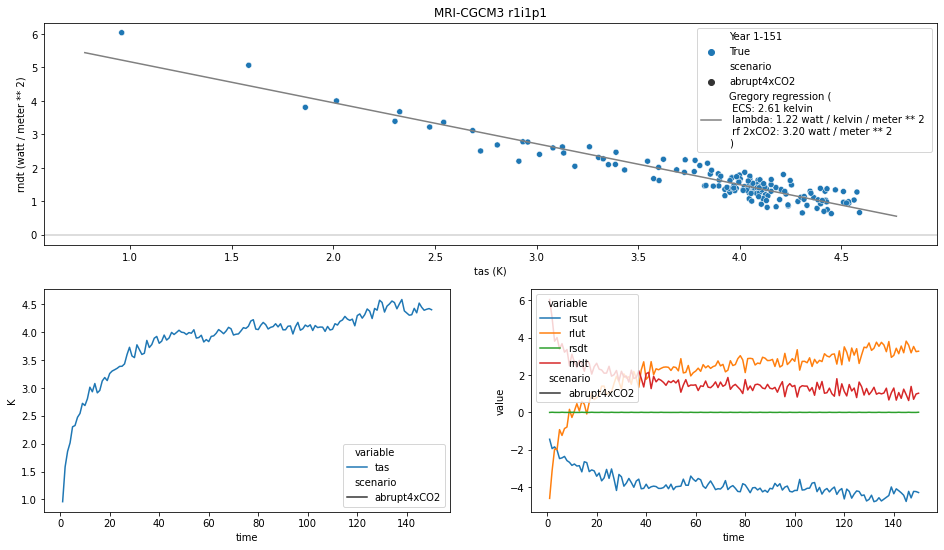

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r20i1p1/**/NORMED*.MAG
set()
Not all data available for MRI-CGCM3 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r21i1p1/**/NORMED*.MAG
set()
Not all data available for MRI-CGCM3 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r22i1p1/**/NORMED*.MAG
set()
Not all data available for MRI-CGCM3 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r23i1p1/**/NORMED*.MAG
set()
Not all data available for MRI-CGCM3 r1i1p1
Missing abrupt-2xCO2
Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/MRI-CGCM3/r2i1p1/**/NORMED*.MAG
set()
Not all data available for MRI-CGCM3 r1i1p1
Missing abrupt-2xCO2
N

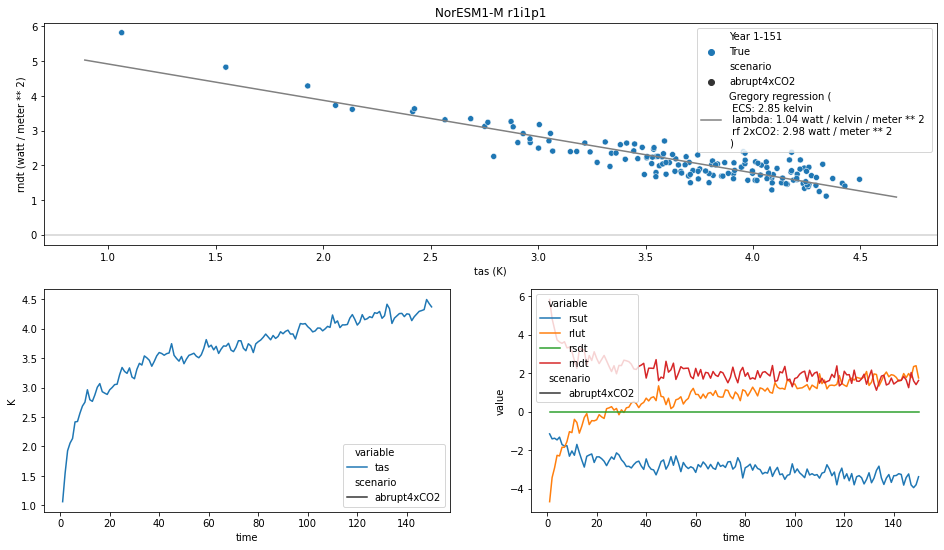

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/bcc-csm1-1-m/r1i1p1/**/NORMED*.MAG
set()
Not all data available for bcc-csm1-1-m r1i1p1
Missing abrupt-2xCO2


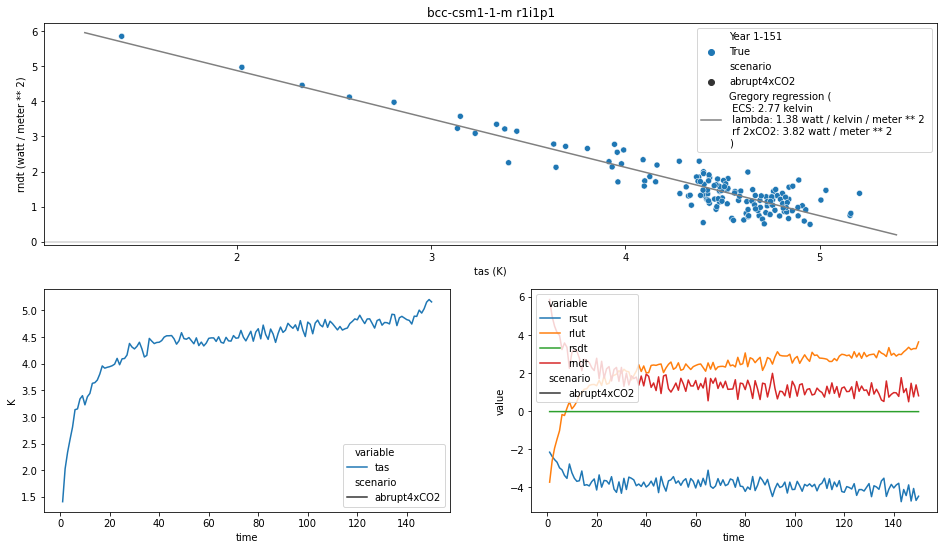

Not all data available for ../data/netcdf-scm/average-year-mid-year/cmip5/abrupt-2xCO2/Amon/tas/bcc-csm1-1/r1i1p1/**/NORMED*.MAG
set()
Not all data available for bcc-csm1-1 r1i1p1
Missing abrupt-2xCO2


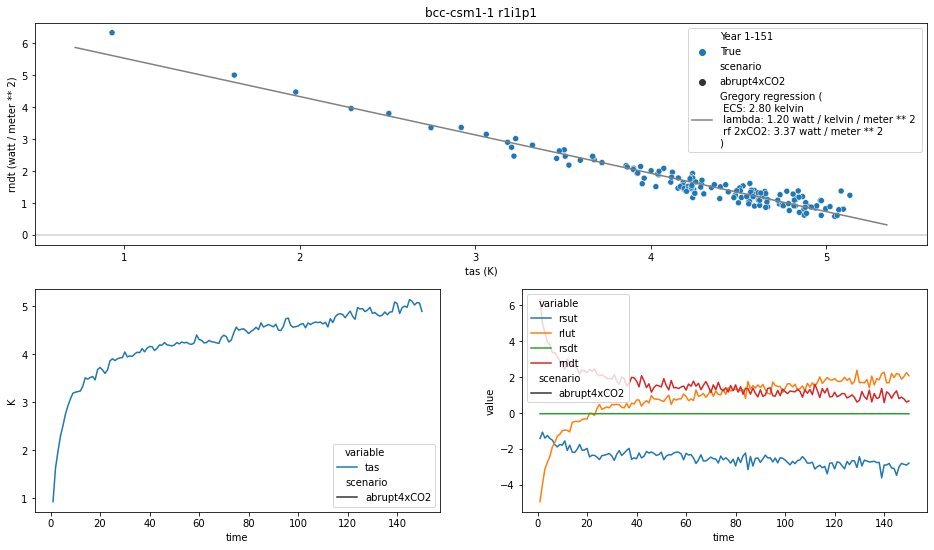

In [15]:
non_tas_variables_to_load = [
    "rsut",
    "rlut",
    "rsdt",
]

out_table = {}

for f in tqdman.tqdm(abrupt_4xco2_tas_files):
    if "cmip5" in f:
        load_kwargs = dict(drs="MarbleCMIP5")
        cmip6 = False
        abrupt_4xCO2_name = "abrupt4xCO2"
    else:
        load_kwargs = dict(drs="CMIP6Output")
        cmip6 = True
        abrupt_4xCO2_name = "abrupt-4xCO2"

    db = []
    for exp, mip in ((abrupt_4xCO2_name, "/CMIP/"), ("abrupt-2xCO2", "/CFMIP/")):
        glob_to_use = (
            os.path.join(*f.split(os.sep)[:-1], "**", "NORMED*.MAG")
            .replace(abrupt_4xCO2_name, exp)
            .replace("/CMIP/", mip)
        )
        fload = find_file(glob_to_use)

        if fload is None:
            print("Not all data available for {} {}".format(climate_model, member_id))
            print("Missing {}".format(exp))
            continue

        tas = force_first_year(
            netcdf_scm.io.load_mag_file(fload, **load_kwargs)
        ).filter(region="World")
        if tas["year"].max() < 20:
            continue

        assert tas.metadata["normalisation method"] == "21-yr-running-mean"

        climate_model = tas.get_unique_meta("climate_model", no_duplicates=True)
        member_id = tas.get_unique_meta("member_id", no_duplicates=True)

        all_data = True
        db.append(tas)
        for v in non_tas_variables_to_load:
            glob_to_use = os.path.join(
                *fload.split(os.sep)[:-1], "NORMED*.MAG"
            ).replace("tas", v)
            found_files = set(glob.glob(glob_to_use, recursive=True))
            if len(found_files) != 1:
                print(glob_to_use)
                print(
                    "Not all data available for {} {}".format(climate_model, member_id)
                )
                print("Missing {}".format(v))
                all_data = False
                break

            db.append(
                force_first_year(
                    netcdf_scm.io.load_mag_file(
                        list(found_files)[0], **load_kwargs
                    ).filter(region="World")
                )
            )

    if not all_data or not db:
        continue

    db = run_append(db)

    db = db.append(
        db.filter(variable="rsdt")
        .subtract(db.filter(variable="rsut"), op_cols={"variable": "rndt"})
        .subtract(db.filter(variable="rlut"), op_cols={"variable": "rndt"})
    )

    fig = plt.figure(figsize=(16, 9))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

    ax1 = fig.add_subplot(spec[1, 0])
    ax2 = fig.add_subplot(spec[1, 1])
    ax3 = fig.add_subplot(spec[0, :])

    db.filter(variable="tas").time_mean("AC").lineplot(
        hue="variable", time_axis="year", ax=ax1, style="scenario"
    )
    db.filter(variable="r*").time_mean("AC").lineplot(
        hue="variable", time_axis="year", ax=ax2, style="scenario"
    )
    make_gregory_plot(db, ax3, style="scenario")
    ax3.axhline(0, color="lightgray")

    plt.show()

    gv = get_gregory_values(db)
    out_dict = {
        "climate_model": climate_model,
        "member_id": member_id,
        "mip_era": db.get_unique_meta("mip_era", no_duplicates=True),
        **gv,
    }

    for k, v in out_dict.items():
        try:
            val = v.magnitude
            unit = v.units
            key = "{} ({})".format(k, unit)
        except AttributeError:
            key = k
            val = v

        if key in out_table:
            out_table[key].append(val)
        else:
            out_table[key] = [val]

#     break

out_table = pd.DataFrame(out_table)

In [16]:
db.head()

time                                                                                                   0001-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario    unit              variable                        
cmip5       bcc-csm1-1    r1i1p1    CMIP5   unspecified World  abrupt4xCO2 K                 tas                  0.930168   
                                                                           W m^-2            rsut                -1.423050   
                                                                                             rlut                -4.949310   
                                                                                             rsdt                -0.039569   
                                                                           watt / meter ** 2 rndt                 6.332791   

time                                                                                                   0002-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario    unit              variable                        
cmip5       bcc-csm1-1    r1i1p1    CMIP5   unspecified World  abrupt4xCO2 K                 tas                  1.626900   
                                                                           W m^-2            rsut                -1.069040   
                                                                                             rlut                -3.974720   
                                                                                             rsdt                -0.039541   
                                                                           watt / meter ** 2 rndt                 5.004219   

time                                                                                                   0003-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario    unit              variable                        
cmip5       bcc-csm1-1    r1i1p1    CMIP5   unspecified World  abrupt4xCO2 K                 tas                  1.977430   
                                                                           W m^-2            rsut                -1.402340   
                                                                                             rlut                -3.110420   
                                                                                             rsdt                -0.039588   
                                                                           watt / meter ** 2 rndt                 4.473172   

time                                                                                                   0004-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario    unit              variable                        
cmip5       bcc-csm1-1    r1i1p1    CMIP5   unspecified World  abrupt4xCO2 K                 tas                  2.293160   
                                                                           W m^-2            rsut                -1.255380   
                                                                                             rlut                -2.741720   
                                                                                             rsdt                -0.039632   
                                                                           watt / meter ** 2 rndt                 3.957468   

time                                                                                                   0005-07-01 00:00:00  \
activity_id climate_model member_id mip_era model       region scenario    unit              variable                        
cmip5       bcc-csm1-1    r1i1p1    CMIP5   unspecified World  abrupt4xCO2 K                 tas                  2.507880   
                                                                           W m^-2         

In [17]:
out_table.head()

climate_model member_id mip_era  lambda (watt / kelvin / meter ** 2)  \
0  AWI-CM-1-1-MR  r1i1p1f1   CMIP6                             1.148273   
1    BCC-CSM2-MR  r1i1p1f1   CMIP6                             1.132325   
2       BCC-ESM1  r1i1p1f1   CMIP6                             0.860692   
3    CAMS-CSM1-0  r1i1p1f1   CMIP6                             1.820750   
4    CAMS-CSM1-0  r2i1p1f1   CMIP6                             1.831601   

   rf_4xco2 (watt / meter ** 2)  rf_2xco2 (watt / meter ** 2)  ecs (kelvin)  
0                      7.260648                      3.630324      3.161551  
1                      6.673837                      3.336919      2.946963  
2                      5.728468                      2.864234      3.327827  
3                      8.341279                      4.170640      2.290616  
4                      8.392830                      4.196415      2.291119

In [18]:
len(out_table[out_table["mip_era"] == "CMIP6"]["climate_model"].unique())

28

In [19]:
len(out_table[out_table["mip_era"] == "CMIP5"]["climate_model"].unique())

21

In [20]:
len(out_table["climate_model"].unique())

49

## Comparing CMIP5 and CMIP6 climate sensitivity

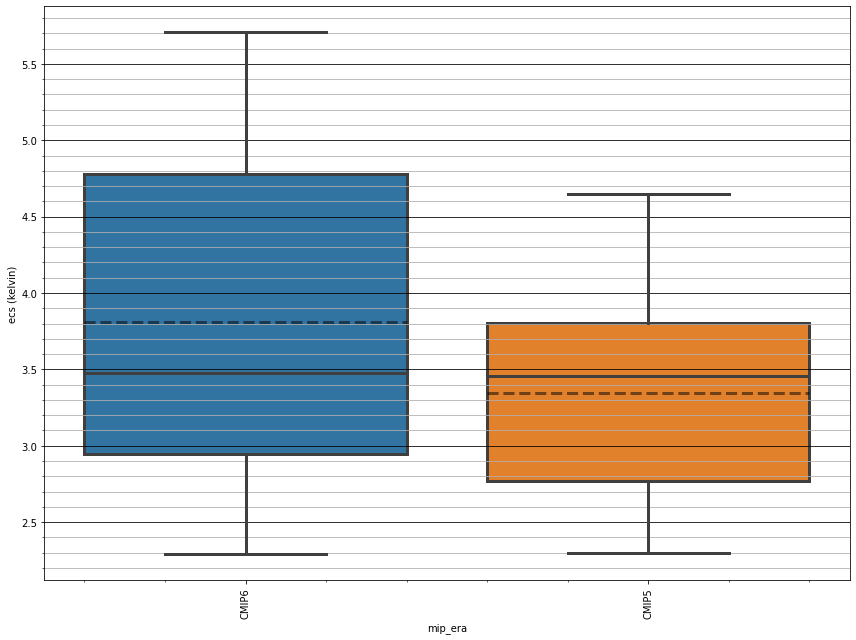

In [21]:
ax = plt.figure(figsize=(12, 9)).add_subplot(111)
sns.boxplot(
    data=out_table.groupby(["climate_model", "mip_era"]).mean().reset_index(),
    x="mip_era",
    y="ecs (kelvin)",
    linewidth=3,
    meanline=True,
    showmeans=True,
    meanprops={"color": "k", "linestyle": "--", "linewidth": 3, "alpha": 0.5},
    ax=ax,
)
ax.grid(which="major", axis="y", color="k")
ax.grid(which="minor", axis="y")
ax.minorticks_on()
plt.xticks(rotation=90)
plt.tight_layout()

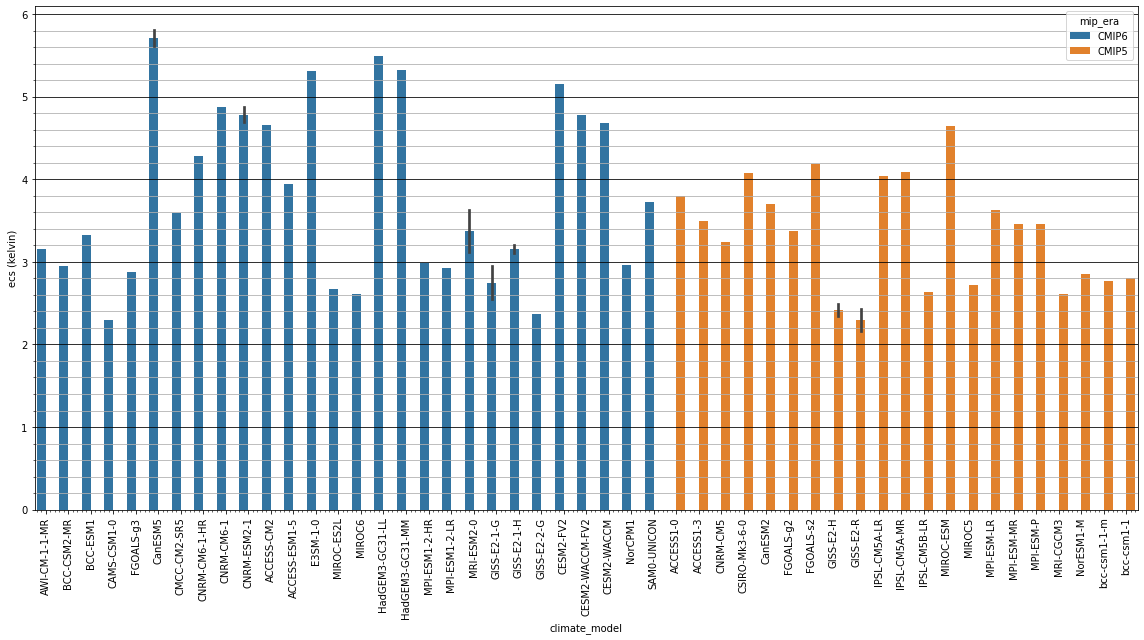

In [22]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
sns.barplot(
    data=out_table, hue="mip_era", x="climate_model", y="ecs (kelvin)", ci="sd", ax=ax
)
ax.grid(which="major", axis="y", color="k")
ax.grid(which="minor", axis="y")
ax.minorticks_on()
plt.xticks(rotation=90)
plt.tight_layout()

In [23]:
(
    out_table.groupby("climate_model").std() / out_table.groupby("climate_model").mean()
).dropna(how="all") * 100

lambda (watt / kelvin / meter ** 2)  \
climate_model                                        
CAMS-CSM1-0                               0.420143   
CNRM-ESM2-1                               6.052267   
CanESM5                                   5.415762   
GISS-E2-1-G                              13.942877   
GISS-E2-1-H                               6.095786   
GISS-E2-H                                 3.052764   
GISS-E2-R                                 7.334353   
MRI-ESM2-0                               24.995835   

               rf_4xco2 (watt / meter ** 2)  rf_2xco2 (watt / meter ** 2)  \
climate_model                                                               
CAMS-CSM1-0                        0.435662                      0.435662   
CNRM-ESM2-1                        3.436913                      3.436913   
CanESM5                            3.011584                      3.011584   
GISS-E2-1-G                       16.680982                     16.680982   
GISS-E2-1-H                        3.943379                      3.943379   
GISS-E2-H                          1.488028                      1.488028   
GISS-E2-R                          0.726649                      0.726649   
MRI-ESM2-0                        16.109355                     16.109355   

               ecs (kelvin)  
climate_model                
CAMS-CSM1-0        0.015520  
CNRM-ESM2-1        2.618076  
CanESM5            2.406140  
GISS-E2-1-G        8.015889  
GISS-E2-1-H        2.154997  
GISS-E2-H          4.539761  
GISS-E2-R          8.058854  
MRI-ESM2-0         8.251827

In [24]:
out_table

climate_model member_id mip_era  lambda (watt / kelvin / meter ** 2)  \
0   AWI-CM-1-1-MR  r1i1p1f1   CMIP6                             1.148273   
1     BCC-CSM2-MR  r1i1p1f1   CMIP6                             1.132325   
2        BCC-ESM1  r1i1p1f1   CMIP6                             0.860692   
3     CAMS-CSM1-0  r1i1p1f1   CMIP6                             1.820750   
4     CAMS-CSM1-0  r2i1p1f1   CMIP6                             1.831601   
..            ...       ...     ...                                  ...   
59      MPI-ESM-P    r1i1p1   CMIP5                             1.231242   
60      MRI-CGCM3    r1i1p1   CMIP5                             1.223258   
61      NorESM1-M    r1i1p1   CMIP5                             1.044665   
62   bcc-csm1-1-m    r1i1p1   CMIP5                             1.380944   
63     bcc-csm1-1    r1i1p1   CMIP5                             1.201143   

    rf_4xco2 (watt / meter ** 2)  rf_2xco2 (watt / meter ** 2)  ecs (kelvin)  
0                       7.260648                      3.630324      3.161551  
1                       6.673837                      3.336919      2.946963  
2                       5.728468                      2.864234      3.327827  
3                       8.341279                      4.170640      2.290616  
4                       8.392830                      4.196415      2.291119  
..                           ...                           ...           ...  
59                      8.523793                      4.261897      3.461460  
60                      6.391380                      3.195690      2.612442  
61                      5.962849                      2.981424      2.853954  
62                      7.643821                      3.821910      2.767608  
63                      6.733997                      3.366999      2.803162  

[64 rows x 7 columns]